In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import time

import sys
import os

from datetime import datetime
import subprocess

os.environ['CUDA_VISIBLE_DEVICES']="0"


from keras.layers import Dense, Input, Dropout, BatchNormalization
from keras.models import Model, Sequential

from keras.regularizers import l2, l1, l1_l2


import tensorflow as tf

from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import EarlyStopping


import pickle


In [2]:
import optree
import keras
print( '\n\n')
print(' optree version:  %s' % str(optree.__version__))
print(' keras version:  %s' % str(keras.__version__))
print('\n\n')




 optree version:  0.13.0
 keras version:  3.4.1





In [3]:
print("\n\n")
print("  numpy version:  %s" % str(np.version.version) )
print("  tensorflow version:  %s" % str(tf.__version__))
print("\n\n")




  numpy version:  1.26.4
  tensorflow version:  2.17.0





In [4]:
from keras.layers import Activation

beta = 4

def custom_activation(x):
    return 0.5 * x * (1 + K.tanh( beta * 0.79788 * (x + 0.044715 * x * x * x)))

## Set model and resolution parameters

In [5]:
##====================

ndim = 1

n_boot_samples = 2

random_seed = 1

resolution_sf = 1.00

output_dir = 'output-run-nn-study-nd-v1a-ndim%d-res-sf-%.2f' % (ndim, resolution_sf)


##-------------

if ndim == 6 :

    mc_mu = [ 1.,  0.,  -0.5,   0.5, -1., 0.3 ]

    mc_rho = [ 
                  [0.0, 0.0, -0.3, 0.2, 0.1],  #0
                  [0.1, 0.3, -0.2, 0.0 ],   #1
                  [0.3, -0.2, 0.1   ],  #2
                  [0.0, 0.1],  #3
                  [0.7],  #4
                ]

    mc_sig = [ 1., 0.7, 1.1, 0.8, 1.2, 1.4 ]


    ##-------------

    true_mu = [ 0.8,  0.1,  -0.6, 0.7, -0.8, 0.1 ]

    true_rho  = [ [0.0, 0.1, -0.2, 0.2, 0.0 ], #0
                  [0.0, 0.2, -0.1, 0.0],  #1
                  [0.4, -0.3, 0.0   ],  #2
                  [0.0, 0.2],  #3
                  [0.5],  #4
                ]

    true_sig = [ 0.8, 0.6, 1.0,    0.6, 1.0, 1.1 ]
    
    
    
    resolution = [ 0.4, 0.5, 0.6,   0.3, 0.4, 0.4  ]
    
    

##-------------

if ndim == 4 :
    
    mc_mu = [ 1.,  0.,  -0.5,   0.5 ]

    mc_rho = [ 
                  [0.3, -0.2, 0.1   ],  #0
                  [0.0, 0.1],  #1
                  [0.7],  #2
                ]

    mc_sig = [ 1., 0.7, 1.1, 0.8 ]
    
    
    ##-------------

    true_mu = [ 0.8,  0.1,  -0.6, 0.7 ]

    true_rho  = [ 
                  [0.4, -0.3, 0.0   ],  #0
                  [0.0, 0.2],  #1
                  [0.5],  #2
                ]

    true_sig = [ 0.8, 0.6, 1.0,    0.6 ]
    
    
    resolution = [ 0.4, 0.5, 0.6,   0.3  ]
    
    

##-------------

if ndim == 2 :
    
    mc_mu = [ 0.0, 1.0 ]

    mc_rho = [ [-0.6] ]

    mc_sig = [ 1.0, 1.5 ]


    ##-------------

    true_mu = [ 0.2, 0.8 ]

    true_rho  = [ [-0.6] ]

    true_sig = [ 0.9, 1.3 ]
    
    
    resolution = [ 0.5, 0.8  ]

    
##-------------

if ndim == 1 :

    ##-------------

    mc_mu = [ 0.0 ]

    mc_rho = [ [0.0] ]

    mc_sig = [ 1.0 ]


    ##-------------


    true_mu = [ 0.2 ]

    true_rho  = [ [0.0] ]

    true_sig = [ 0.9 ]  

    
    resolution = [ 0.5  ]









##=====================


#-- scale resolution 

for i in range( len(resolution) ) :
    resolution[i] = resolution_sf * resolution[i]
print('\n\n Resolution: %s\n\n' % str(resolution))


mc_cov = np.zeros( shape=(ndim,ndim) )
true_cov  = np.zeros( shape=(ndim,ndim) )

print("\n\n\n mc covariance:")

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if i == j :
            mc_cov[i][j] = mc_sig[i] * mc_sig[j]
            print("  %2d, %2d : diagonal  %8.4f" % (i,j, mc_cov[i][j]))
        else :
            k = ndim - j - 1
            mc_cov[i][j] = mc_sig[i] * mc_sig[j] * mc_rho[i][k]
            mc_cov[j][i] = mc_cov[i][j]
            print("  %2d, %2d :           %8.3f * %8.3f * %8.3f = %8.4f" % 
                  (i,j, mc_sig[i], mc_sig[j], mc_rho[i][k], mc_cov[i][j]))
            
            

print("\n\n\n True covariance:")  

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if i == j :
            true_cov[i][j] = true_sig[i] * true_sig[j]
            print("  %2d, %2d : diagonal  %8.4f" % (i,j, true_cov[i][j]))
        else :
            k = ndim - j - 1
            true_cov[i][j] = true_sig[i] * true_sig[j] * true_rho[i][k]
            true_cov[j][i] = true_cov[i][j]
            print("  %2d, %2d :           %8.3f * %8.3f * %8.3f = %8.4f" % 
                  (i,j, true_sig[i], true_sig[j], true_rho[i][k], true_cov[i][j]))
            
            
                

                
                






ngen_mc = 100000
ngen_true =  10000



of_niter = 5

learning_rate_setval = 0.0005





epochs_setval = 50

#patience_setval = 25
patience_setval = -1

restore_best_weights_setval = False



l1reg_kernel_setval = 0.0
l2reg_kernel_setval = 0.0
l1reg_activation_setval = 0.0
l2reg_activation_setval = 0.0
l1reg_bias_setval = 0.0
l2reg_bias_setval = 0.0



use_batch_norm = False

units_per_layer = 50


number_of_layers = 3




dropout_setval = 0.0


batch_size_setval = int( ngen_true )






#activation_setval = 'relu'

activation_setval = custom_activation





do_bootstrap = False




use_poisson_fluctuations_around_ngen_true = True


n_models_to_ensemble = 10



save_step2_model = False




 Resolution: [0.5]





 mc covariance:
   0,  0 : diagonal    1.0000



 True covariance:
   0,  0 : diagonal    0.8100


In [6]:
try:
    os.mkdir( output_dir )
except:
    print('\n\n Output directory already exists:  %s' % output_dir)
    #print('\n\n HALTING EXECUTION\n\n')
    #sys.exit()



 Output directory already exists:  output-run-nn-study-nd-v1a-ndim1-res-sf-1.00


In [7]:
print("\n\n")
print("mc covariance determinant:  %f" % np.linalg.det( mc_cov ) )
print("True covariance determinant:   %f" % np.linalg.det( true_cov ) )
print("\n\n")




mc covariance determinant:  1.000000
True covariance determinant:   0.810000





In [8]:
mc_cov_inv = np.linalg.inv( mc_cov )

In [9]:
mc_cov_inv_test = np.matmul( mc_cov, mc_cov_inv )

In [10]:
print("\n\n")
print(" mc covariance")
print( mc_cov )
print("\n mc covariance inverse")
print( mc_cov_inv )
print("\n mc covariance inverse test")
print(mc_cov_inv_test)
print("\n\n")




 mc covariance
[[1.]]

 mc covariance inverse
[[1.]]

 mc covariance inverse test
[[1.]]





In [11]:
true_cov_inv = np.linalg.inv( true_cov )

In [12]:
true_cov_inv_test = np.matmul( true_cov, true_cov_inv )

In [13]:
print("\n\n")
print(" True covariance")
print( true_cov )
print("\n True covariance inverse")
print( true_cov_inv )
print("\n True covariance inverse test")
print(true_cov_inv_test)
print("\n\n")




 True covariance
[[0.81]]

 True covariance inverse
[[1.2345679]]

 True covariance inverse test
[[1.]]





## Generate samples, save events and config

In [14]:

np.random.seed( random_seed )
keras.utils.set_random_seed( random_seed )


mc_pts = np.random.multivariate_normal(mc_mu, mc_cov, size=ngen_mc)
true_pts = np.random.multivariate_normal(true_mu, true_cov, size=ngen_true)

mc_det_pts = np.random.normal( mc_pts, resolution )

true_det_pts = np.random.normal( true_pts, resolution )


true_pts10x = np.random.multivariate_normal(true_mu, true_cov, size=ngen_true*40)
true_det_pts10x = np.random.normal( true_pts10x, resolution )
true_pts10x_weights = np.ones( ngen_true*40 )
true_pts10x_weights = (1./40.) * true_pts10x_weights



In [15]:
with open( '%s/mc-and-true-samples.npy' % output_dir, 'wb') as f :
    np.save(f, mc_pts)
    np.save(f, mc_det_pts)
    np.save(f, true_pts)
    np.save(f, true_det_pts)

In [16]:
with open('%s/config-pars.pkl' % output_dir, 'wb') as f :
    pickle.dump( mc_mu, f)
    pickle.dump( mc_rho, f)
    pickle.dump( mc_sig, f)
    pickle.dump( true_mu,f)
    pickle.dump( true_rho,f)
    pickle.dump( true_sig,f)
    pickle.dump( resolution,f)
    pickle.dump( mc_cov,f)
    pickle.dump( true_cov,f)


In [17]:
config_filename = '%s/config.txt' % output_dir

config_file = open( config_filename, 'w' )

config_file.write('%s\n\n' % datetime.now() )
config_file.write('ngen_mc %d\n' % ngen_mc )
config_file.write('ngen_true  %d\n' % ngen_true )
config_file.write('of_niter   %d\n' % of_niter )
config_file.write('ndim       %d\n' % ndim )
config_file.write('learning_rate_setval  %f\n' % learning_rate_setval )
config_file.write('epochs_setval  %d\n' % epochs_setval )
config_file.write('batch_size_setval  %d\n' % batch_size_setval )
config_file.write('use_poisson_fluctuations_around_total : %s\n' % str(use_poisson_fluctuations_around_ngen_true) )
config_file.write( 'random_seed:  %d\n' % random_seed  )

config_file.write('l1reg_kernel_setval  %s\n' % l1reg_kernel_setval )
config_file.write('l2reg_kernel_setval  %s\n' % l2reg_kernel_setval )
config_file.write('l1reg_activation_setval  %s\n' % l1reg_activation_setval )
config_file.write('l2reg_activation_setval  %s\n' % l2reg_activation_setval )
config_file.write('l1reg_bias_setval  %s\n' % l1reg_bias_setval )
config_file.write('l2reg_bias_setval  %s\n' % l2reg_bias_setval )

config_file.write('activation_setval  %s\n' % activation_setval )
config_file.write('beta  %s\n' % beta )
config_file.write('patience_setval  %d\n' % patience_setval )
config_file.write('restore_best_weights_setval  %s\n' % str(restore_best_weights_setval) )
config_file.write('n_models_to_ensemble  %d\n' % n_models_to_ensemble )


config_file.write('\n\n')
config_file.write('mc_mu : %s\n' % str(mc_mu))
config_file.write('mc_rho : %s\n' % str(mc_rho))
config_file.write('mc_sig : %s\n' % str(mc_sig))
config_file.write('mc_cov : %s\n' % str(mc_cov))
config_file.write('\n\n')
config_file.write('true_mu : %s\n' % str(true_mu))
config_file.write('true_rho : %s\n' % str(true_rho))
config_file.write('true_sig : %s\n' % str(true_sig))
config_file.write('true_cov : %s\n' % str(true_cov))
config_file.write('\n\n')
config_file.write('resolution_sf :  %.2f\n' % resolution_sf )
config_file.write('resolution : %s\n' % str(resolution) )
config_file.close()

print('\n\n  Config file contents : %s\n' % config_filename )
print( subprocess.getoutput('cat %s' % config_filename ))
print('\n\n')





  Config file contents : output-run-nn-study-nd-v1a-ndim1-res-sf-1.00/config.txt

2025-03-28 13:26:02.957432

ngen_mc 100000
ngen_true  10000
of_niter   5
ndim       1
learning_rate_setval  0.000500
epochs_setval  50
batch_size_setval  10000
use_poisson_fluctuations_around_total : True
random_seed:  1
l1reg_kernel_setval  0.0
l2reg_kernel_setval  0.0
l1reg_activation_setval  0.0
l2reg_activation_setval  0.0
l1reg_bias_setval  0.0
l2reg_bias_setval  0.0
activation_setval  <function custom_activation at 0x7b3487992f80>
beta  4
patience_setval  -1
restore_best_weights_setval  False
n_models_to_ensemble  10


mc_mu : [0.0]
mc_rho : [[0.0]]
mc_sig : [1.0]
mc_cov : [[1.]]


true_mu : [0.2]
true_rho : [[0.0]]
true_sig : [0.9]
true_cov : [[0.81]]


resolution_sf :  1.00
resolution : [0.5]





## Plots to visualize these parameter choices

<function matplotlib.pyplot.show(close=None, block=None)>

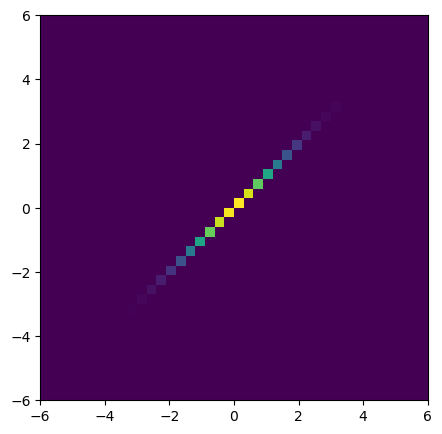

In [18]:
fig,ax = plt.subplots( ndim, ndim, figsize=(ndim*5, ndim*5))

hmin=-6
hmax=6
hbins=40

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if ndim == 1 :
            axi = ax
        else :
            axi = ax[i][j]
        axi.hist2d( mc_pts[:,i], mc_pts[:,j], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))



plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

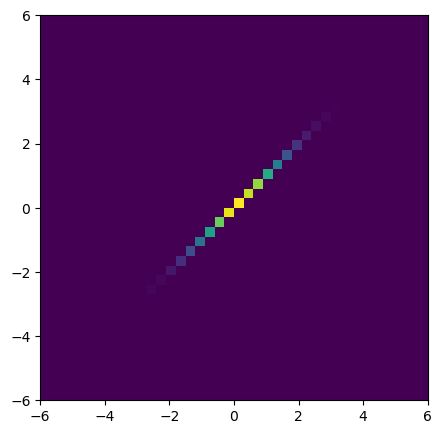

In [19]:
fig,ax = plt.subplots( ndim, ndim, figsize=(ndim*5, ndim*5))

hmin=-6
hmax=6
hbins=40

for i in range(ndim) :
    for j in range(ndim) :
        if j < i : continue
        if ndim == 1 :
            axi = ax
        else :
            axi = ax[i][j]
        axi.hist2d( true_pts[:,i], true_pts[:,j], bins=[hbins,hbins], range=([hmin,hmax],[hmin,hmax]))



plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

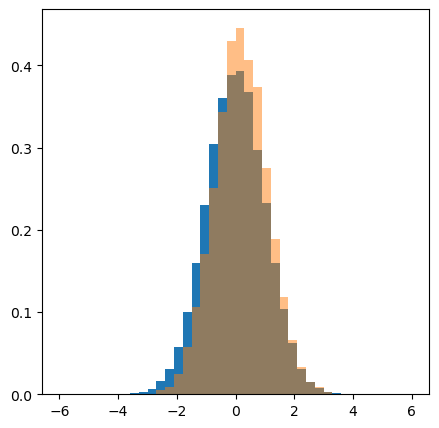

In [20]:
fig,ax = plt.subplots( 1, ndim, figsize=(ndim*5,5))

hmin=-6
hmax=6
hbins=40


for i in range(ndim) :
        k = i*3 + j
        if ndim == 1 :
            axi = ax
        else :
            axi = ax[i]
        axi.hist( mc_pts[:,i],bins=hbins, range=[hmin,hmax], density=True )
        axi.hist( true_pts[:,i],bins=hbins, range=[hmin,hmax], density=True, alpha=0.5 )
    
plt.show

### Calculate true weights analytically and compare with unfolding output weights.

In [21]:
mc_pts_minus_mc_mu = mc_pts - mc_mu
mc_pts_minus_true_mu = mc_pts - true_mu
true_cov_inv_times_v = np.tensordot( true_cov_inv, mc_pts_minus_true_mu.T, axes=(1,0) )
v_times_true_cov_inv_times_v =  np.sum( mc_pts_minus_true_mu.T * true_cov_inv_times_v, axis=0)
mc_cov_inv_times_v = np.tensordot( mc_cov_inv, mc_pts_minus_mc_mu.T, axes=(1,0) )
v_times_mc_cov_inv_times_v =  np.sum( mc_pts_minus_mc_mu.T * mc_cov_inv_times_v, axis=0)
exp_v_times_mc_cov_inv_times_v = np.exp( -0.5 * v_times_mc_cov_inv_times_v )
exp_v_times_true_cov_inv_times_v  = np.exp( -0.5 * v_times_true_cov_inv_times_v  )
true_cov_det = np.linalg.det( true_cov )
mc_cov_det = np.linalg.det( mc_cov )
norm2_true = np.power( 3.14159265, ndim) * true_cov_det
print("\n norm2_true : %f\n" % norm2_true )
norm2_train = np.power( 3.14159265, ndim) * mc_cov_det
print("\n norm2_train : %f\n" % norm2_train )
pdf_train = exp_v_times_mc_cov_inv_times_v / np.sqrt(norm2_train)
print(pdf_train)
pdf_true = exp_v_times_true_cov_inv_times_v / np.sqrt(norm2_true)
print(pdf_true)
pdf_ratio = pdf_true / pdf_train
sample_sf = (1.*len(true_pts))/(1.*len(mc_pts))
print('\n sample_sf = %f' % sample_sf )
calc_weight = pdf_ratio
calc_weight_scaled = sample_sf * pdf_ratio
print('\n Calculated weights :  %s\n' % str(calc_weight))


 norm2_true : 2.544690


 norm2_train : 3.141593

[0.15082819 0.46790598 0.49073665 ... 0.56233152 0.53176755 0.42665263]
[0.17918702 0.4173781  0.45189319 ... 0.62144199 0.61889934 0.36014781]

 sample_sf = 0.100000

 Calculated weights :  [1.18802069 0.89201275 0.92084663 ... 1.10511677 1.16385316 0.8441242 ]



## Set up NN model for OmniFold

In [22]:

import tensorflow.keras.backend as K


def weighted_binary_crossentropy(y_true, y_pred):
    weights = tf.gather(y_true, [1], axis=1) # event weights
    y_true = tf.gather(y_true, [0], axis=1) # actual y_true for loss

    # Clip the prediction value to prevent NaN's and Inf's
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

    t_loss = -weights * ((y_true) * K.log(y_pred) +
                         (1 - y_true) * K.log(1 - y_pred))

    return K.mean(t_loss)

In [23]:

reg_setval_zero = 0.0


model_step1 = Sequential()

model_step1.add( Dense(units_per_layer, input_dim=ndim, activation=activation_setval, 
                       kernel_regularizer=l1_l2(l1reg_kernel_setval, l2reg_kernel_setval), 
                       bias_regularizer=l1_l2(l1reg_bias_setval, l2reg_bias_setval),
                       activity_regularizer=l1_l2(l1reg_activation_setval, l2reg_activation_setval) ) )
if use_batch_norm : model_step1.add( BatchNormalization() )
model_step1.add( Dropout(dropout_setval) )

if number_of_layers > 1 :
    model_step1.add( Dense(units_per_layer, activation=activation_setval, 
                       kernel_regularizer=l1_l2(l1reg_kernel_setval, l2reg_kernel_setval), 
                       bias_regularizer=l1_l2(l1reg_bias_setval, l2reg_bias_setval), 
                       activity_regularizer=l1_l2(l1reg_activation_setval, l2reg_activation_setval) ) )
    if use_batch_norm : model_step1.add( BatchNormalization() )
    model_step1.add( Dropout(dropout_setval) )

if number_of_layers > 2 :
    model_step1.add( Dense(units_per_layer, activation=activation_setval, 
                       kernel_regularizer=l1_l2(l1reg_kernel_setval, l2reg_kernel_setval), 
                       bias_regularizer=l1_l2(l1reg_bias_setval, l2reg_bias_setval),
                       activity_regularizer=l1_l2(l1reg_activation_setval, l2reg_activation_setval) ) )
    if use_batch_norm : model_step1.add( BatchNormalization() )
    model_step1.add( Dropout(dropout_setval) )

model_step1.add( Dense(1, activation='sigmoid') )





model_step2 = Sequential()

model_step2.add( Dense(units_per_layer, input_dim=ndim, activation=activation_setval, 
                       kernel_regularizer=l1_l2(l1reg_kernel_setval, l2reg_kernel_setval), 
                       bias_regularizer=l1_l2(l1reg_bias_setval, l2reg_bias_setval), 
                       activity_regularizer=l1_l2(l1reg_activation_setval, l2reg_activation_setval) ) )
if use_batch_norm : model_step2.add( BatchNormalization() )
model_step2.add( Dropout(dropout_setval) )

if number_of_layers > 1 :
    model_step2.add( Dense(units_per_layer, activation=activation_setval, 
                       kernel_regularizer=l1_l2(l1reg_kernel_setval, l2reg_kernel_setval), 
                       bias_regularizer=l1_l2(l1reg_bias_setval, l2reg_bias_setval),
                       activity_regularizer=l1_l2(l1reg_activation_setval, l2reg_activation_setval) ) )
    if use_batch_norm : model_step2.add( BatchNormalization() )
    model_step2.add( Dropout(dropout_setval) )

if number_of_layers > 2 :
    model_step2.add( Dense(units_per_layer, activation=activation_setval, 
                       kernel_regularizer=l1_l2(l1reg_kernel_setval, l2reg_kernel_setval), 
                       bias_regularizer=l1_l2(l1reg_bias_setval, l2reg_bias_setval),
                       activity_regularizer=l1_l2(l1reg_activation_setval, l2reg_activation_setval) ) )
    if use_batch_norm : model_step2.add( BatchNormalization() )
    model_step2.add( Dropout(dropout_setval) )

model_step2.add( Dense(1, activation='sigmoid') )


#----








opt_step1 = tf.keras.optimizers.Adam( learning_rate=learning_rate_setval )
opt_step2 = tf.keras.optimizers.Adam( learning_rate=learning_rate_setval )



model_step1.compile(loss=weighted_binary_crossentropy,
                      optimizer=opt_step1,
                      metrics=['accuracy'])

model_step2.compile(loss=weighted_binary_crossentropy,
                      optimizer=opt_step2,
                      metrics=['accuracy'])

print('\n\n ------ model_step1:')
model_step1.summary()

print('\n\n ------ model_step2:')
model_step2.summary()




 ------ model_step1:


/usr/lib/python3/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1743193563.310133 2843797 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1743193563.355739 2843797 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1743193563.356027 2843797 cuda_executor.cc:1015] successful NUMA n

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 50)             │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,251 (20.51 KB)

 Trainable params: 5,251 (20.51 KB)

 Non-trainable params: 0 (0.00 B)



 ------ model_step2:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 50)             │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,251 (20.51 KB)

 Trainable params: 5,251 (20.51 KB)

 Non-trainable params: 0 (0.00 B)

## Show some model structure details

In [24]:
for li in range(len(model_step1.layers)) :
    print( ' \n layer index %2d : name = %s' % (li, model_step1.layers[li].name) )
    if 'dropout' in model_step1.layers[li].name : continue
    for gwi in range( len( model_step1.layers[li].get_weights() )) :
        print( ' %3d, %3d : shape %s' % (li, gwi, str(model_step1.layers[li].get_weights()[gwi].shape)) )
        print( ' %3d, %3d : range %5.3f to %5.3f' % (li, gwi, 
                                                     np.min(model_step1.layers[li].get_weights()[gwi]),
                                                     np.max(model_step1.layers[li].get_weights()[gwi]),
                                                    ))
        #print( ' %3d : %s' % (gwi, str(model_step1.layers[li].get_weights()[gwi])) )
    

 
 layer index  0 : name = dense
   0,   0 : shape (1, 50)
   0,   0 : range -0.332 to 0.317
   0,   1 : shape (50,)
   0,   1 : range 0.000 to 0.000
 
 layer index  1 : name = dropout
 
 layer index  2 : name = dense_1
   2,   0 : shape (50, 50)
   2,   0 : range -0.244 to 0.245
   2,   1 : shape (50,)
   2,   1 : range 0.000 to 0.000
 
 layer index  3 : name = dropout_1
 
 layer index  4 : name = dense_2
   4,   0 : shape (50, 50)
   4,   0 : range -0.245 to 0.245
   4,   1 : shape (50,)
   4,   1 : range 0.000 to 0.000
 
 layer index  5 : name = dropout_2
 
 layer index  6 : name = dense_3
   6,   0 : shape (50, 1)
   6,   0 : range -0.338 to 0.312
   6,   1 : shape (1,)
   6,   1 : range 0.000 to 0.000


## Define and test function to reset the model weights

In [25]:
def reset_model_weights( model, verb=False ) :
    print('Resetting weights for model %s' % model)
    for li in range(len(model.layers)) :
        if verb : print( ' \n layer index %2d : name = %s' % (li, model.layers[li].name) )
        if 'dropout' in model.layers[li].name : continue
        weights, biases = model.layers[li].get_weights()
        weight_shape_sum = np.sum( weights.shape )
        weight_max = np.sqrt(6/weight_shape_sum)
        weight_min = -1 * weight_max
        new_weights = np.random.uniform( weight_min, weight_max, weights.shape )
        if verb :
            print( ' %3d : weights shape %s, sum %d, range [%.3f,%.3f], biases shape %s' % 
                  (li, str(weights.shape), weight_shape_sum, 
                   weight_min, weight_max, str(biases.shape)))
            print( ' old weights: %s  %s' % (str(weights.shape), str(weights) ) )
            print( ' new weights: %s  %s' % (str(new_weights.shape), str(new_weights) ) )
        new_biases = np.zeros( biases.shape )
        model.layers[li].set_weights( (new_weights, new_biases) )



In [26]:
reset_model_weights( model_step1, True )

Resetting weights for model <Sequential name=sequential, built=True>
 
 layer index  0 : name = dense
   0 : weights shape (1, 50), sum 51, range [-0.343,0.343], biases shape (50,)
 old weights: (1, 50)  [[-0.16532475  0.24863651  0.30074033 -0.1075376  -0.32141355 -0.2673044
   0.03090587 -0.3316933   0.20339629 -0.14942357  0.10079813 -0.25830868
   0.0825716  -0.10257767  0.0199126  -0.28733498 -0.13361053  0.00521564
   0.31718615 -0.1651984  -0.2568717  -0.08432898  0.08647963  0.28655908
   0.14245641 -0.18244745  0.26371685 -0.1597968  -0.2208426  -0.21553177
  -0.2888135   0.16521445  0.01792762 -0.29514092 -0.31574255 -0.12182599
  -0.05630437  0.05392244  0.24212024  0.1461601   0.18804327 -0.09003153
  -0.09783542  0.22503605 -0.02793458 -0.07739317 -0.01772612  0.16438016
   0.30223647  0.2928616 ]]
 new weights: (1, 50)  [[-6.53931890e-02  8.41141369e-02 -3.02980734e-02 -3.17578760e-01
   5.03902476e-02 -8.63835865e-02 -1.56967225e-01 -3.99855410e-02
  -3.37292236e-01 -1.9

## Package the training data for OmniFold

In [27]:
mc_both = np.stack([mc_pts, mc_det_pts], axis=1)

## Define the OmniFold function

In [28]:
def reweight(events,model,batch_size=10000):
    f = model.predict(events, batch_size=batch_size, verbose=0)
    epsilon = K.epsilon()
    f = K.clip( f, epsilon, 1. - epsilon )  #owen: protect against divide by zero.
    weights = f / (1. - f)
    return np.squeeze(np.nan_to_num(weights))


In [29]:
def omnifold(theta0,theta_unknown_S,iterations, model_step1, model_step2, verbose=0,
             batch_size_setval=10000, epochs_setval=20,
             save_step2_model=False, output_dir="./", patience_setval=5,
             restore_best_weights_setval=False):

    ensemble_weights = np.empty(shape=(n_models_to_ensemble, iterations, 2, len(theta0)))

    ensemble_final_push_weights = np.empty( shape=(n_models_to_ensemble, len(theta0)) )
    
    
    weights = np.empty(shape=(iterations, 2, len(theta0)))
    # shape = (iteration, step, event)
    push_weights_for_output = np.empty(shape=(iterations, len(theta0)))

    ensemble_push_weights_for_output = np.empty( shape=(n_models_to_ensemble, iterations, len(theta0)) )

    ensemble_pull_weights_for_output = np.empty( shape=(n_models_to_ensemble, iterations, len(theta0)) )

    
    
    
    
    
    theta0_G = theta0[:,0]
    theta0_S = theta0[:,1]

    labels0 = np.zeros(len(theta0))
    labels_unknown = np.ones(len(theta_unknown_S))
    labels_unknown_step2 = np.ones(len(theta0_G))

    premc_xvals_1 = np.concatenate((theta0_S, theta0_S))
    premc_yvals_1 = np.concatenate( (np.ones(len(theta0_S)), np.zeros(len(theta0_S))) )
    xvals_1 = np.concatenate((theta0_S, theta_unknown_S))
    yvals_1 = np.concatenate((labels0, labels_unknown))

    premc_xvals_2 = np.concatenate((theta0_G, theta0_G))
    premc_yvals_2 = np.concatenate( (np.ones(len(theta0_G)), np.zeros(len(theta0_G))) )
    xvals_2 = np.concatenate((theta0_G, theta0_G))
    yvals_2 = np.concatenate((labels0, labels_unknown_step2))

    if verbose :
        print("\n\n")
        print("  ======== omnifold\n\n")
        print("  shape of theta0_S : %s" % str(np.shape(theta0_S)) ) ;
        print("  shape of theta_unknown_S : %s" % str(np.shape(theta_unknown_S)) ) ;
        print("  shape of xvals_1 :  %s" % str(np.shape( xvals_1 )) ) ;
        print("\n\n")
        print("  shape of labels0 : %s" % str(np.shape(labels0)) ) ;
        print("  shape of labels_unknown : %s" % str(np.shape(labels_unknown)) ) ;
        print("  shape of yvals_1 :  %s" % str(np.shape( yvals_1 )) ) ;
        print("\n\n")
        print("  shape of theta0_G : %s" % str(np.shape(theta0_G)) ) ;
        print("  shape of xvals_2 :  %s" % str(np.shape( xvals_2 )) ) ;
        print("  shape of yvals_2 :  %s" % str(np.shape( yvals_2 )) ) ;
        print("\n batch size setval  %d" % batch_size_setval )
        print(" epochs setval  %d" % epochs_setval )
        print("\n\n")

    # initial iterative weights are ones
    weights_pull = np.ones(len(theta0_S))
    weights_push = np.ones(len(theta0_S))


    # owen: rescale the MC weights to balance the two categories for step 1 in first iteration.
    mc_weight_sf = (1.*len(theta_unknown_S))/(1.*len(theta0_S))

    

        
    fitverbose = 0
    if verbose > 1 : fitverbose = 1
        
    

    return_dict = {}
    
#--------- Begin loop over ensembles
  
    for ei in range( n_models_to_ensemble ) :


        if (verbose>0) :
            print('\n\n\n ++++++++++++++ Begin Ensemble %2d ++++++++++++++++\n\n' % ei )

        reset_model_weights( model_step1 )  

        reset_model_weights( model_step2 )

        weights_pull = np.ones(len(theta0_S))
        weights_push = np.ones(len(theta0_S))

    
#------------- Begin loop over iterations

        for i in range(iterations):

            if (verbose>0):
                print("\nITERATION: {}\n".format(i + 1))
                pass

            # STEP 1: classify Sim. (which is reweighted by weights_push) to Data
            # weights reweighted Sim. --> Data

            if (verbose>0):
                print("   -- ITERATION %d  STEP 1\n" % (i+1) )
                pass

            print(" weights_push at the beginning")
            print( weights_push )



         # owen: put the scaling here so that weights_push keeps its meaning (order 1).
            weights_1 = np.concatenate((mc_weight_sf * weights_push, np.ones(len(theta_unknown_S))))

            X_mc_1, X_test_1, Y_mc_1, Y_test_1, w_mc_1, w_test_1 = train_test_split(xvals_1, yvals_1, weights_1)

            # zip ("hide") the weights with the labels
            Y_mc_1 = np.stack((Y_mc_1, w_mc_1), axis=1)
            Y_test_1 = np.stack((Y_test_1, w_test_1), axis=1)
            
            
            
            if verbose>0 : print(' Iter %d, step 1, ensemble index %d' % (i, ei) )
            
            
            
            if i > -1 :

                    premc_weights_1 = np.concatenate( (np.ones(len(theta0_S)), np.ones(len(theta0_S))) )

                    pt_X_mc_1, pt_X_test_1, pt_Y_mc_1, pt_Y_test_1, pt_w_mc_1, pt_w_test_1 = train_test_split(premc_xvals_1, premc_yvals_1, premc_weights_1)

                    pt_Y_mc_1 = np.stack((pt_Y_mc_1, pt_w_mc_1), axis=1)
                    pt_Y_test_1 = np.stack((pt_Y_test_1, pt_w_test_1), axis=1)

                    if verbose>0 :
                            print("             running pre-training, distinguish from self.")

                    model_step1.fit( pt_X_mc_1, pt_Y_mc_1, epochs=5, batch_size=batch_size_setval, verbose=False )

                    if verbose>0 :
                            print("             done pretraining.")

                            
                            
                            
                            
            this_epochs = epochs_setval
            if i == 0 : this_epochs = this_epochs*2
        
            earlystopping = EarlyStopping(patience=patience_setval, verbose=True, 
                                          restore_best_weights=restore_best_weights_setval)

            if patience_setval >= 0 :
                cbl = [earlystopping]
            else :
                cbl = []
                
            mc_history_step1 = model_step1.fit(X_mc_1,
                                                  Y_mc_1,
                                                  epochs=this_epochs,
                                                  batch_size=batch_size_setval,
                                                  validation_data=(X_test_1, Y_test_1),
                                                  verbose=fitverbose,
                                                  callbacks=cbl )

            
            ensemble_weights[ei, i, 0, :] = reweight(theta0_S,model_step1)
            
            print(' Ensemble %2d, Iteration %d, step 1, weights' % (ei, i))
            print( ensemble_weights[ei, i, 0, :] )
        
        
            step1_output_weights = reweight(theta0_S,model_step1)
            

            weights_pull = weights_push * step1_output_weights

            weights[i, :1, :] = step1_output_weights

            return_dict["mc-hist-step1-iter%d" % i] = mc_history_step1

            return_dict['model_weights_step1_iter%d' % i] = np.copy( model_step1.layers[0].get_weights()[0] )

            return_dict['model_biases_step1_iter%d' % i] = np.copy( model_step1.layers[0].get_weights()[1] )

            ensemble_pull_weights_for_output[ei,i,:] = weights_pull

            
            
            
            
            

            # STEP 2: classify Gen. to reweighted Gen. (which is reweighted by weights_pull)
            # weights Gen. --> reweighted Gen.

            if (verbose>0):
                print("\n   -- ITERATION %d  STEP 2\n" % (i+1) )
                pass

            
            if verbose>0 : print(' Iter %d, step 2, ensemble index %d' % (i, ei) )

            # ones for Gen. (not MC weights), actual weights for (reweighted) Gen.
            weights_2 = np.concatenate((   weights_push  , weights_pull))

            X_mc_2, X_test_2, Y_mc_2, Y_test_2, w_mc_2, w_test_2 = train_test_split(xvals_2, yvals_2, weights_2)

            # zip ("hide") the weights with the labels
            Y_mc_2 = np.stack((Y_mc_2, w_mc_2), axis=1)
            Y_test_2 = np.stack((Y_test_2, w_test_2), axis=1)

            if i > -1 :

                    premc_weights_2 = np.concatenate( (np.ones(len(theta0_G)), np.ones(len(theta0_G))) )

                    pt_X_mc_2, pt_X_test_2, pt_Y_mc_2, pt_Y_test_2, pt_w_mc_2, pt_w_test_2 = train_test_split(premc_xvals_2, premc_yvals_2, premc_weights_2)

                    pt_Y_mc_2 = np.stack((pt_Y_mc_2, pt_w_mc_2), axis=1)
                    pt_Y_test_2 = np.stack((pt_Y_test_2, pt_w_test_2), axis=1)

                    if verbose>0 :
                            print("             running pre-training, distinguish from self.")

                    model_step2.fit( pt_X_mc_2, pt_Y_mc_2, epochs=5, batch_size=batch_size_setval, verbose=fitverbose )

                    if verbose>0 :
                            print("             done pretraining.")

            earlystopping = EarlyStopping(patience=patience_setval, verbose=True,
                                          restore_best_weights=restore_best_weights_setval)
            if patience_setval >= 0 :
                cbl = [earlystopping]
            else :
                cbl = []

            mc_history_step2 = model_step2.fit(X_mc_2,
                                                  Y_mc_2,
                                                  epochs=this_epochs,
                                                  batch_size=batch_size_setval,
                                                  validation_data=(X_test_2, Y_test_2),
                                                  callbacks=cbl,
                                                  verbose=fitverbose )

            return_dict["mc-hist-step2-iter%d" % i] = mc_history_step2

            return_dict['model_weights_step2_iter%d' % i] = np.copy( model_step2.layers[0].get_weights()[0] )

            return_dict['model_biases_step2_iter%d' % i] = np.copy( model_step2.layers[0].get_weights()[1] )


            ensemble_weights[ei, i, 1, :] = reweight(theta0_G,model_step2)

            print(' Ensemble %2d, Iteration %d, step 2, weights' % (ei, i))
            print( ensemble_weights[ei, i, 1, :] )        


            step2_output_weights = reweight(theta0_G,model_step2)

            weights_push = step2_output_weights * weights_push

            #push_weights_for_output[i] = weights_push
            
            ensemble_push_weights_for_output[ei,i,:] = weights_push

            weights[i, 1:2, :] = step2_output_weights

            if save_step2_model :
                model_output_dir = "%s/of-step2-iter%02d-ensemble%02d-model" % (output_dir, i, ei)
                print("\n +++ Saving step 2, iteration %d model in %s" % (i, model_output_dir) )
                model_step2.save( "%s.keras" % model_output_dir )
                
                
    #----------- End loop over iterations
                
        ensemble_final_push_weights[ei,:] = weights_push
        
    #------- End loop over ensembles

    if verbose>0 :
        print('\n Done with loop over ensembles.  Now averaging final push weights.')

    return_dict["final_push_weights"] = np.average( ensemble_final_push_weights, axis=0 )

    push_weights_for_output = np.average( ensemble_push_weights_for_output, axis=0 )

    pull_weights_for_output = np.average( ensemble_pull_weights_for_output, axis=0 )
    
    return_dict["weights"] = weights
    
    return_dict["ensemble_weights"] = ensemble_weights

    return_dict['ensemble_final_push_weights'] = ensemble_final_push_weights

    return_dict["push_weights"] = push_weights_for_output

    return_dict["pull_weights"] = pull_weights_for_output    
    
    



    
    return return_dict


## Run OmniFold

In [30]:
%%time


verbose = True







of_return_dict = omnifold( 
    mc_both, true_det_pts, of_niter, model_step1, model_step2, verbose, 
    batch_size_setval, epochs_setval,
    save_step2_model, output_dir,
    patience_setval, restore_best_weights_setval
)


of_weights = of_return_dict["weights"]

mc_weight_sf = (1.*len(true_det_pts))/(1.*len(mc_both))

push_weights = of_return_dict["push_weights"]
push_weights_scaled = np.copy( push_weights )
push_weights_scaled = mc_weight_sf * push_weights

pull_weights = of_return_dict["pull_weights"]

final_push_weights = of_return_dict["final_push_weights"]
final_push_weights_scaled = np.copy(final_push_weights)
final_push_weights_scaled = mc_weight_sf * final_push_weights

ensemble_final_push_weights = of_return_dict['ensemble_final_push_weights']

with open( '%s/omnifold-output-weights.npy' % output_dir, 'wb') as f :
    np.save(f, final_push_weights_scaled)





  ======== omnifold


  shape of theta0_S : (100000, 1)
  shape of theta_unknown_S : (10000, 1)
  shape of xvals_1 :  (110000, 1)



  shape of labels0 : (100000,)
  shape of labels_unknown : (10000,)
  shape of yvals_1 :  (110000,)



  shape of theta0_G : (100000, 1)
  shape of xvals_2 :  (200000, 1)
  shape of yvals_2 :  (200000,)

 batch size setval  10000
 epochs setval  50






 ++++++++++++++ Begin Ensemble  0 ++++++++++++++++


Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>

ITERATION: 1

   -- ITERATION 1  STEP 1

 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Iter 0, step 1, ensemble index 0
             running pre-training, distinguish from self.


I0000 00:00:1743193564.645639 2844079 service.cc:146] XLA service 0x7b2f08005010 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743193564.645682 2844079 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-03-28 13:26:04.694581: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-03-28 13:26:04.788330: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
I0000 00:00:1743193565.409725 2844079 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


             done pretraining.
 Ensemble  0, Iteration 0, step 1, weights
[1.14803219 0.90808731 0.64497107 ... 1.15061104 1.1319015  0.95720065]

   -- ITERATION 1  STEP 2

 Iter 0, step 2, ensemble index 0
             running pre-training, distinguish from self.
             done pretraining.
 Ensemble  0, Iteration 0, step 2, weights
[1.15501964 0.93220675 0.95310837 ... 1.08485866 1.12602496 0.89721107]

ITERATION: 2

   -- ITERATION 2  STEP 1

 weights_push at the beginning
[1.15501964 0.93220675 0.95310837 ... 1.08485866 1.12602496 0.89721107]
 Iter 1, step 1, ensemble index 0
             running pre-training, distinguish from self.
             done pretraining.
 Ensemble  0, Iteration 1, step 1, weights
[1.00914443 0.97471499 0.88089424 ... 1.0379256  1.03388071 0.98641694]

   -- ITERATION 2  STEP 2

 Iter 1, step 2, ensemble index 0
             running pre-training, distinguish from self.
             done pretraining.
 Ensemble  0, Iteration 1, step 2, weights
[0.98540598

             done pretraining.
 Ensemble  2, Iteration 2, step 2, weights
[1.01943552 1.00739586 1.00844646 ... 1.01350451 1.01648629 1.00517535]

ITERATION: 4

   -- ITERATION 4  STEP 1

 weights_push at the beginning
[1.1556305  0.92690419 0.95304071 ... 1.13049323 1.1896908  0.88315209]
 Iter 3, step 1, ensemble index 2
             running pre-training, distinguish from self.
             done pretraining.
 Ensemble  2, Iteration 3, step 1, weights
[0.97031397 0.99539679 0.9307965  ... 0.98652923 0.99175882 1.00276637]

   -- ITERATION 4  STEP 2

 Iter 3, step 2, ensemble index 2
             running pre-training, distinguish from self.
             done pretraining.
 Ensemble  2, Iteration 3, step 2, weights
[0.9669705  0.98847389 0.98995644 ... 0.98929256 0.98464304 0.98504227]

ITERATION: 5

   -- ITERATION 5  STEP 1

 weights_push at the beginning
[1.11746061 0.91622059 0.94346879 ... 1.11838855 1.17142077 0.86994214]
 Iter 4, step 1, ensemble index 2
             running pre-t

             done pretraining.
 Ensemble  5, Iteration 0, step 1, weights
[1.17228484 0.88071376 0.663629   ... 1.14787292 1.1344651  0.92846638]

   -- ITERATION 1  STEP 2

 Iter 0, step 2, ensemble index 5
             running pre-training, distinguish from self.
             done pretraining.
 Ensemble  5, Iteration 0, step 2, weights
[1.18513453 0.91174346 0.93266171 ... 1.08104575 1.11480904 0.88028193]

ITERATION: 2

   -- ITERATION 2  STEP 1

 weights_push at the beginning
[1.18513453 0.91174346 0.93266171 ... 1.08104575 1.11480904 0.88028193]
 Iter 1, step 1, ensemble index 5
             running pre-training, distinguish from self.
             done pretraining.
 Ensemble  5, Iteration 1, step 1, weights
[0.96428967 0.99360853 0.85000437 ... 1.04663765 1.05085194 1.01315975]

   -- ITERATION 2  STEP 2

 Iter 1, step 2, ensemble index 5
             running pre-training, distinguish from self.
             done pretraining.
 Ensemble  5, Iteration 1, step 2, weights
[0.9725309 

             done pretraining.
 Ensemble  7, Iteration 2, step 2, weights
[1.00894737 0.98856235 0.99006063 ... 0.99996257 1.00263083 0.98615563]

ITERATION: 4

   -- ITERATION 4  STEP 1

 weights_push at the beginning
[1.1924095  0.91494275 0.94457657 ... 1.11483061 1.15534339 0.86544796]
 Iter 3, step 1, ensemble index 7
             running pre-training, distinguish from self.
             done pretraining.
 Ensemble  7, Iteration 3, step 1, weights
[0.97969007 0.98983425 1.01453638 ... 0.99197292 0.99237758 0.98775917]

   -- ITERATION 4  STEP 2

 Iter 3, step 2, ensemble index 7
             running pre-training, distinguish from self.
             done pretraining.
 Ensemble  7, Iteration 3, step 2, weights
[0.98053819 0.99601912 0.9949789  ... 0.98797637 0.98390949 0.99786609]

ITERATION: 5

   -- ITERATION 5  STEP 1

 weights_push at the beginning
[1.16920305 0.91130047 0.93983376 ... 1.1014263  1.13675332 0.86360118]
 Iter 4, step 1, ensemble index 7
             running pre-t

In [31]:
def hist_to_func( hist_bin_data, xe, ye ) :
    
    return_array = np.zeros( hist_bin_data.shape[0] )
    
    xvals = np.zeros( hist_bin_data.shape[0] )
    yvals = np.zeros( hist_bin_data.shape[0] )
    
    for bi in range( hist_bin_data.shape[0] ) :
        xvals[bi] = 0.5 * (xe[bi] + xe[bi+1] )
        yvals[bi] = 0.5 * (ye[bi] + ye[bi+1] )

    
    for bi0 in range(hist_bin_data.shape[0]) :
        esum = 0
        biesum = 0    
        for bi1 in range(hist_bin_data.shape[1]) :
            esum += hist_bin_data[bi0,bi1]
            #biesum += bi1*hist_bin_data[bi0,bi1]
            biesum += yvals[bi1]*hist_bin_data[bi0,bi1]

        wave = 0
        if esum > 0 :
            wave = biesum / esum
        return_array[bi0] = wave
        
    return return_array, xvals


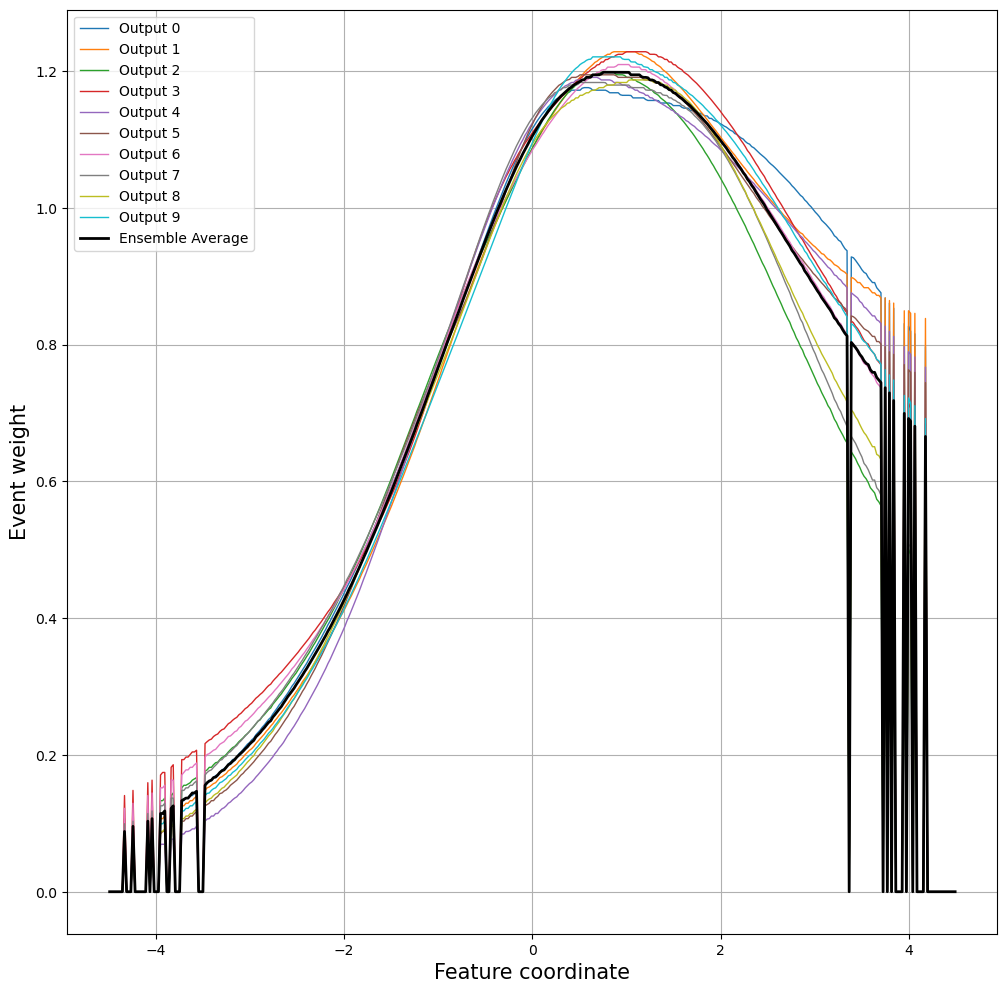

In [32]:
if ndim == 1 :
    
    hbins=400
    
    hpw,xe,ye = np.histogram2d( mc_pts[:,0], final_push_weights[:], bins=[hbins,hbins], range=([-4.5,4.5],[0.,1.5]) )
    

    ave_fpw, xvals = hist_to_func( hpw, xe, ye )
    
    ensemble_weight_functions = np.zeros( shape=(n_models_to_ensemble, hbins) )

    for ei in range( n_models_to_ensemble ) : 
        hpw,xe,ye = np.histogram2d( mc_pts[:,0], ensemble_final_push_weights[ei,:], 
                       bins=[hbins,hbins], range=([-4.5,4.5],[0.,1.5]) )
        ensemble_weight_functions[ei,:],_ = hist_to_func( hpw, xe, ye )
    

    fig,ax = plt.subplots( 1, 1, figsize=(12,12))
    
    axi = ax

    ls = '-'
    msty = ''
    msz = 2
    lwd = 1
    
    for ei in range( n_models_to_ensemble ) :
        axi.plot( xvals, ensemble_weight_functions[ei], label='Output %d' % ei,
                 linestyle=ls, marker=msty, markersize=msz, linewidth=lwd )



    axi.plot( xvals, ave_fpw, label='Ensemble Average',
             color='black', linestyle=ls, marker=msty, markersize=1.5*msz, linewidth=2*lwd )
    
    axi.set_xlabel('Feature coordinate', fontsize=15)
    axi.set_ylabel('Event weight', fontsize=15)
    
    axi.legend()
    
    plt.grid(True)

    plt.show
    

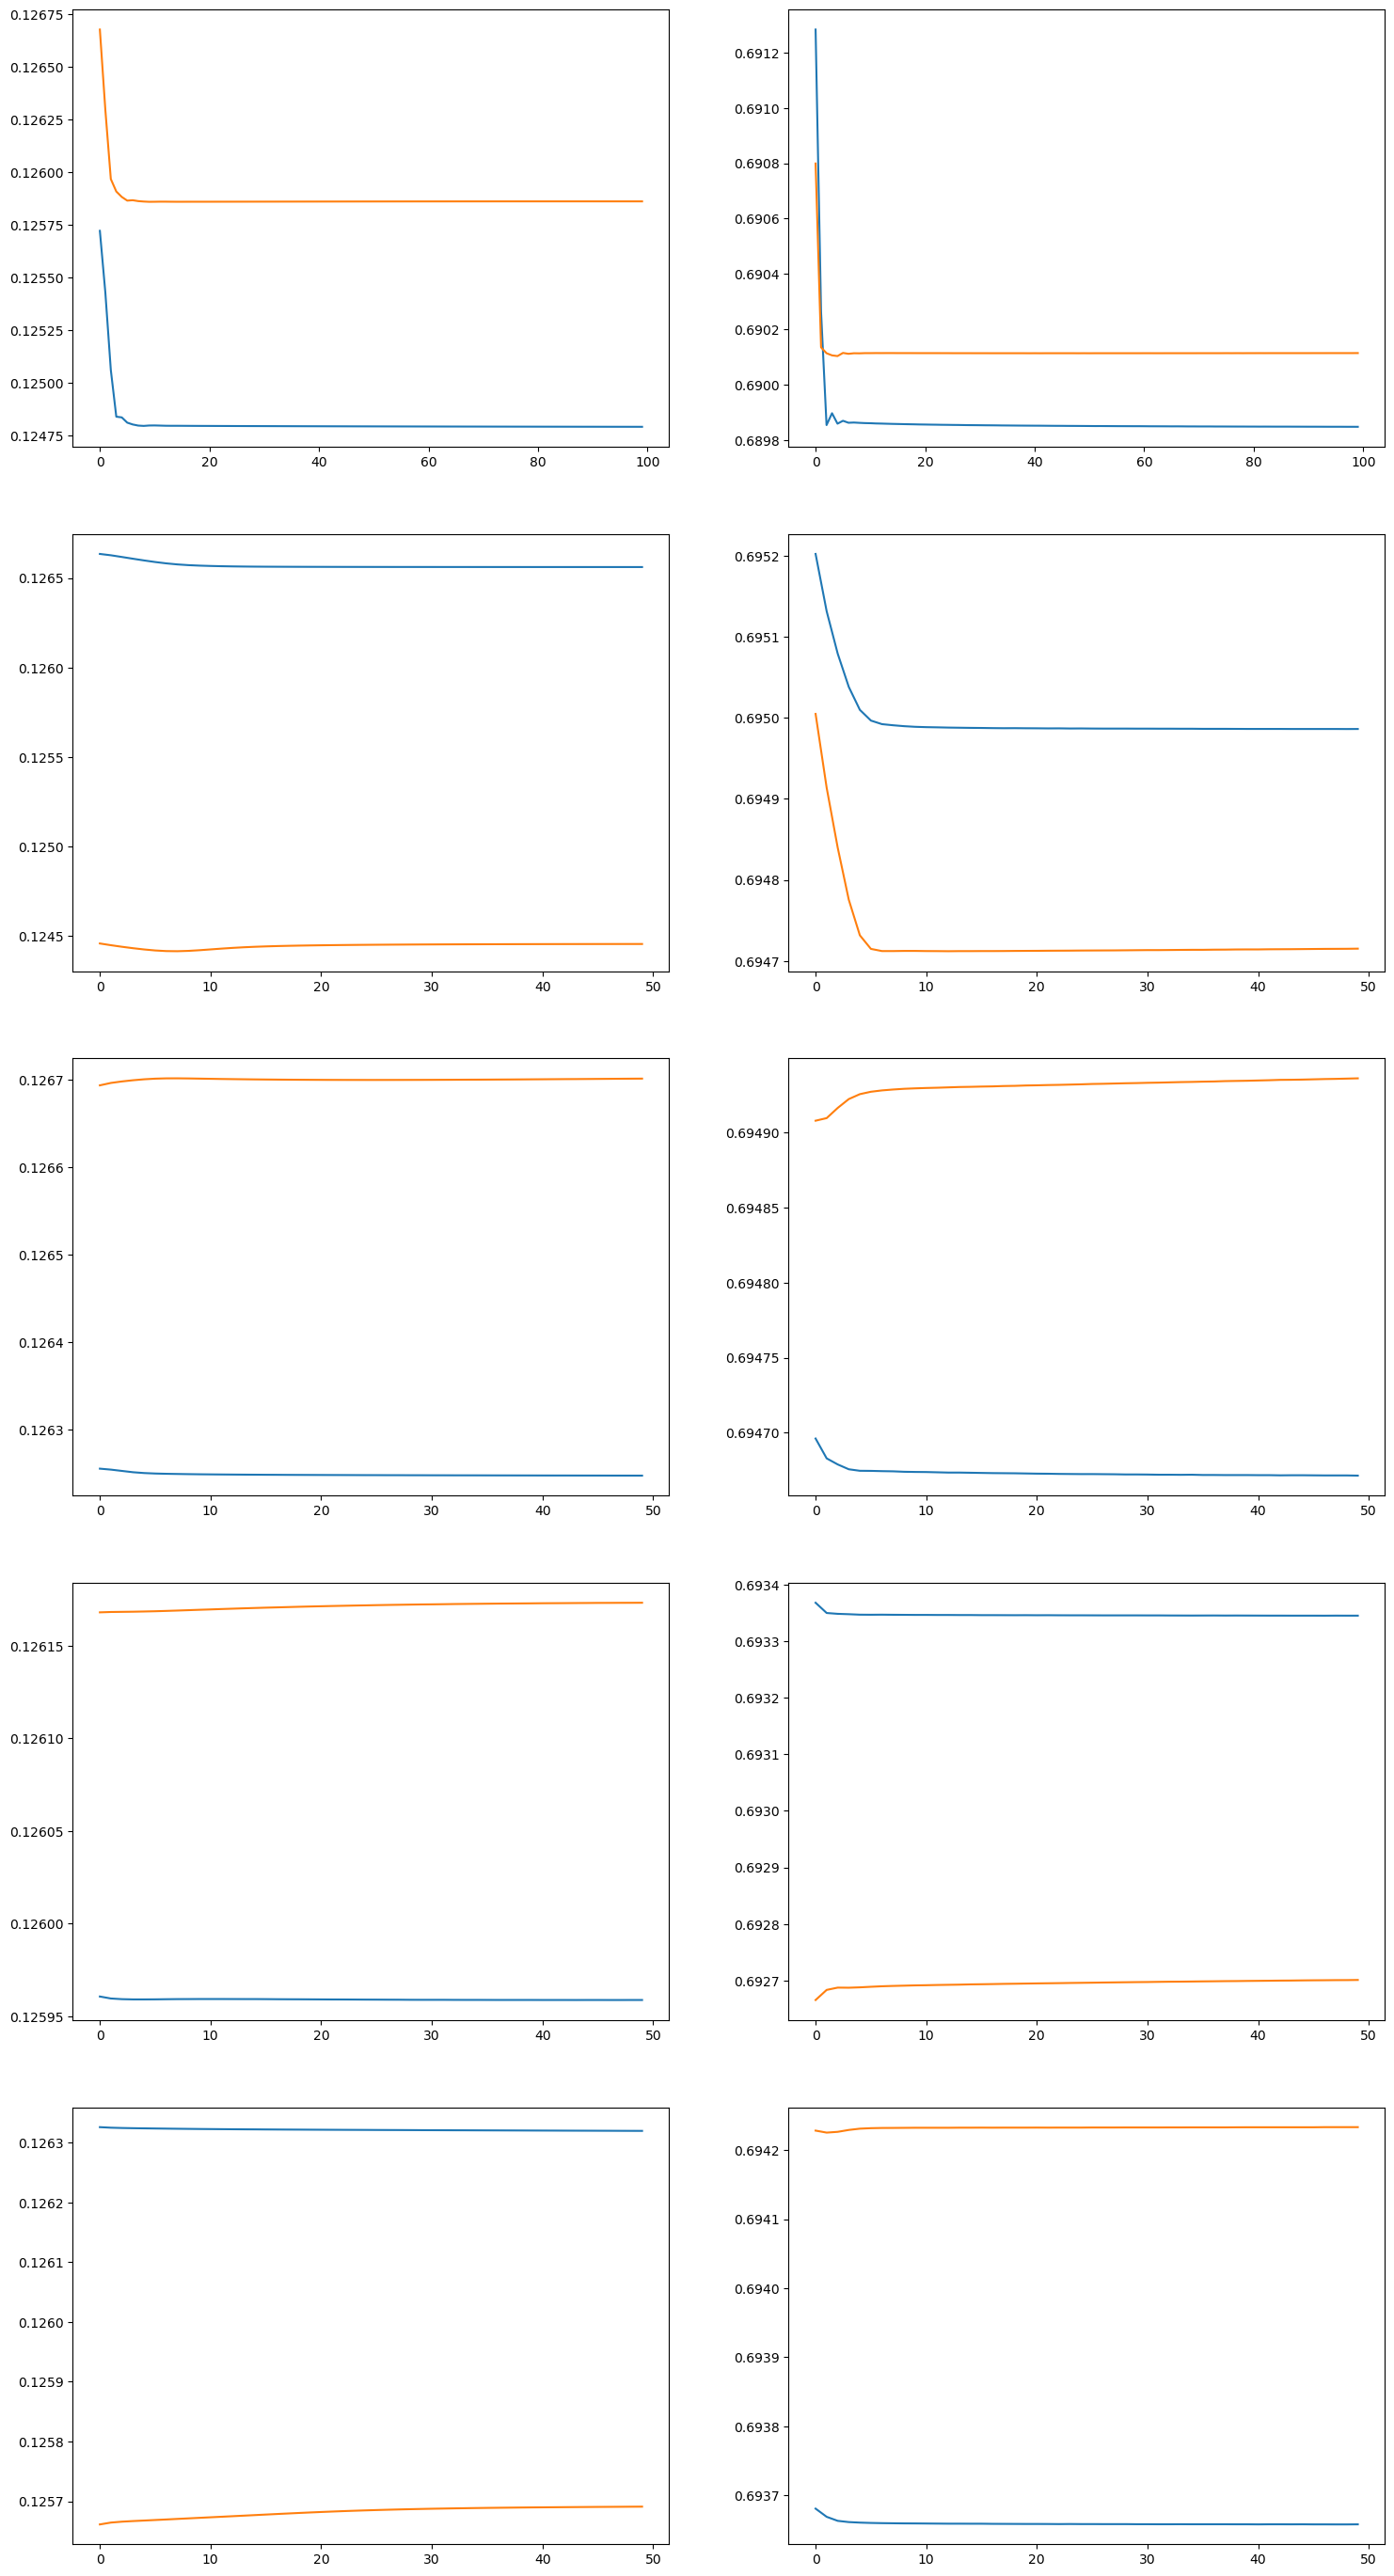

In [33]:
fig,ax = plt.subplots( of_niter, 2, figsize=(18,7*of_niter))

for ofi in range(0,of_niter) :
    
    ax[ofi][0].plot( of_return_dict['mc-hist-step1-iter%d' % ofi].history['loss']  )
    ax[ofi][0].plot( of_return_dict['mc-hist-step1-iter%d' % ofi].history['val_loss']  )

    ax[ofi][1].plot( of_return_dict['mc-hist-step2-iter%d' % ofi].history['loss']  )
    ax[ofi][1].plot( of_return_dict['mc-hist-step2-iter%d' % ofi].history['val_loss']  )
    



<function matplotlib.pyplot.show(close=None, block=None)>

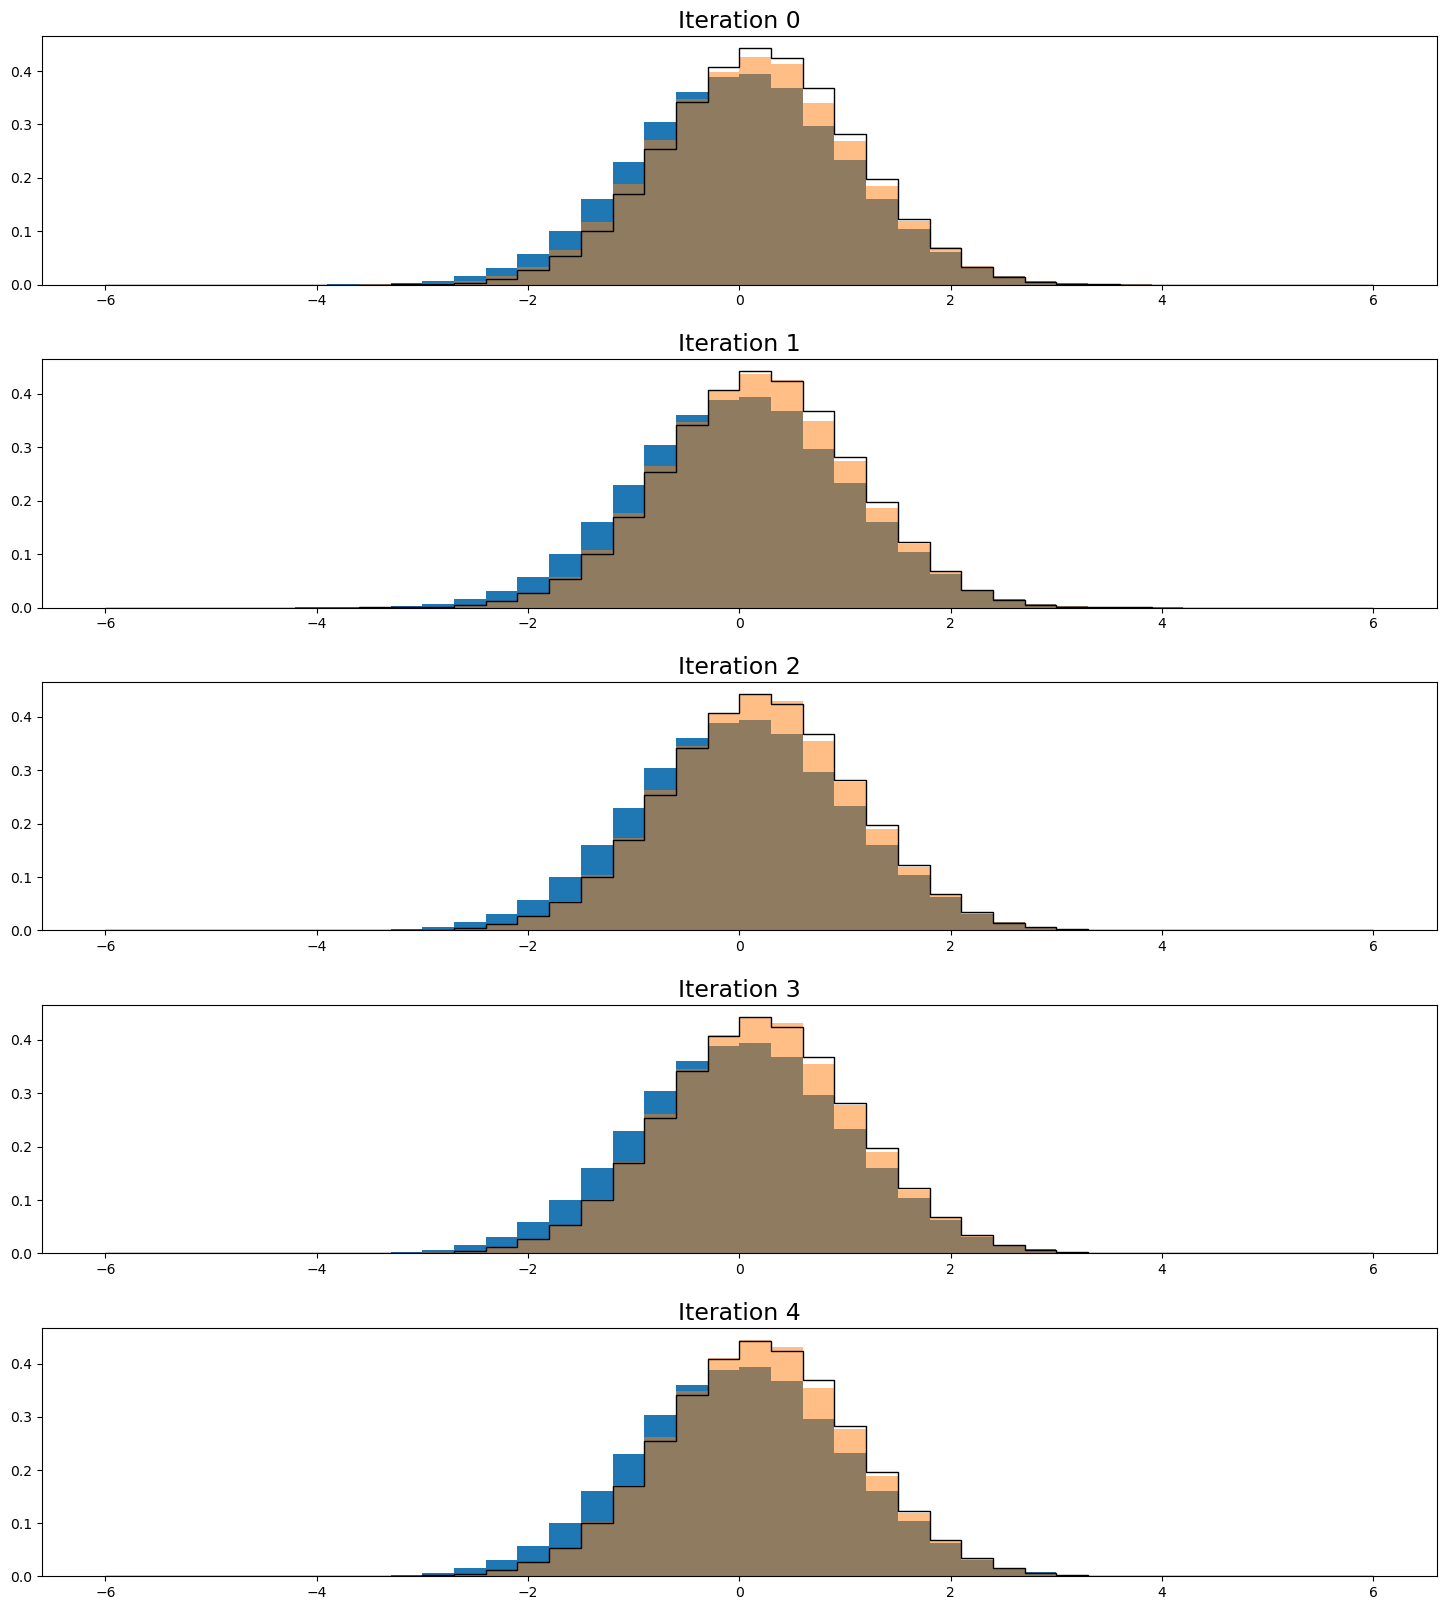

In [34]:



fig,ax = plt.subplots( of_niter, ndim, figsize=(18,4*of_niter))

hmin=-6
hmax=6
hbins=40

hist_data_mc_ofweighted = np.zeros( shape=(of_niter,ndim,hbins))
hist_data_truth         = np.zeros( shape=(of_niter,ndim,hbins))

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

do_renorm = True


for ofi in range(0,of_niter) :

    if do_renorm :
        
        for di in range(ndim) :
            
            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
            
            thisax.hist( mc_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='mc particle' )
            hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( mc_pts[:,di], weights=push_weights[ofi], bins=hbins, density=True, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )            
            hist_data_truth[ofi,di],_,_ =         thisax.hist( true_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, density=True, range=[hmin,hmax], label='true particle', histtype='step', color='black' )

    else :
        
        for di in range(ndim) :

            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
                
            hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( mc_pts[:,di], weights=push_weights_scaled[ofi], bins=hbins, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )            
            hist_data_truth[ofi,di],_,_ =         thisax.hist( true_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, range=[hmin,hmax], label='true particle', histtype='step', color='black' )
        

    

 
    if ndim > 1 :
        thisax = ax[ofi][0]
    else :
        thisax = ax[ofi]
        
    thisax.set_title('Iteration %d' % ofi, fontsize=lfontsize )



plt.show

In [35]:
hist_data_diff = hist_data_mc_ofweighted - hist_data_truth
hist_data_diff2 = hist_data_diff * hist_data_diff

hist_data_sum_diff2 = np.zeros( shape=(of_niter,ndim))

for ofi in range( of_niter ) :
    for di in range( ndim ) :
        hist_data_sum_diff2[ofi,di] = np.sum( hist_data_diff2[ofi,di])


<function matplotlib.pyplot.show(close=None, block=None)>

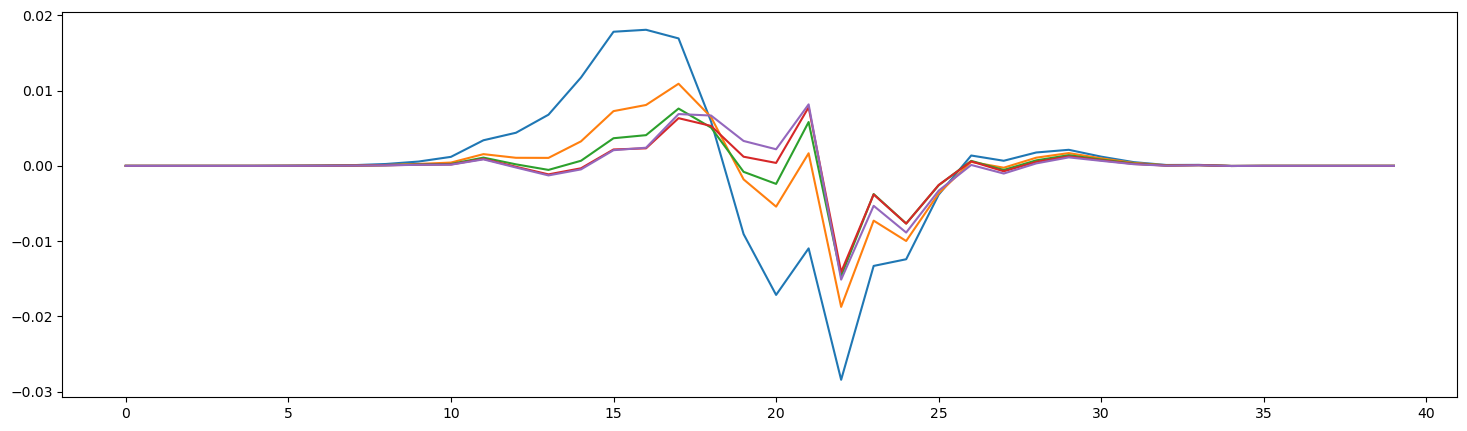

In [36]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

for ofi in range(of_niter) :
    for di in range( ndim ) :
        if ndim == 1 :
            axi = ax
        else :
            axi = ax[di]
        axi.plot(hist_data_diff[ofi,di])

    
plt.show   

<function matplotlib.pyplot.show(close=None, block=None)>

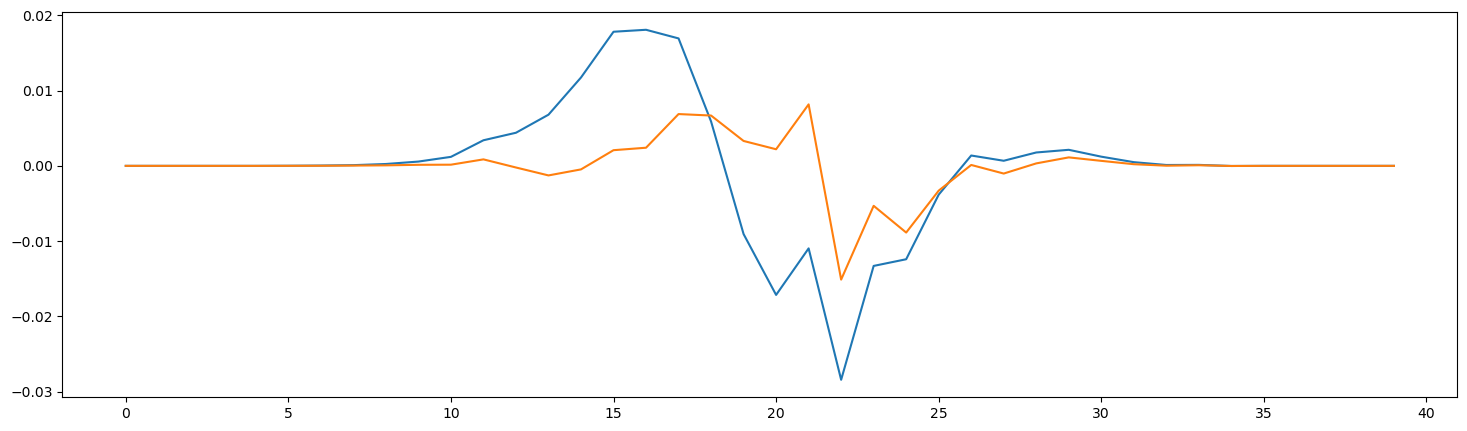

In [37]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

ofi = 0
for di in range( ndim ) :
    if ndim == 1 :
        axi = ax
    else :
        axi = ax[di]
    axi.plot(hist_data_diff[ofi,di])

ofi = of_niter-1
for di in range( ndim ) :
    if ndim == 1 :
        axi = ax
    else :
        axi = ax[di]
    axi.plot(hist_data_diff[ofi,di])

    
plt.show  

<function matplotlib.pyplot.show(close=None, block=None)>

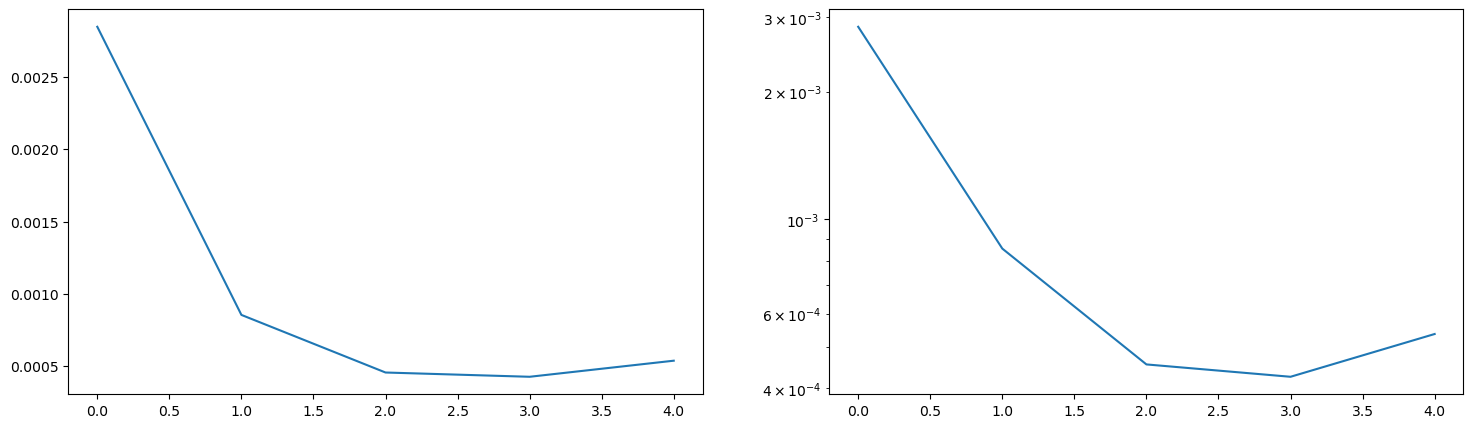

In [38]:
fig,ax = plt.subplots( 1, 2, figsize=(18,5))
ax[0].plot( hist_data_sum_diff2)
ax[1].plot( hist_data_sum_diff2)
ax[1].set_yscale('log')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

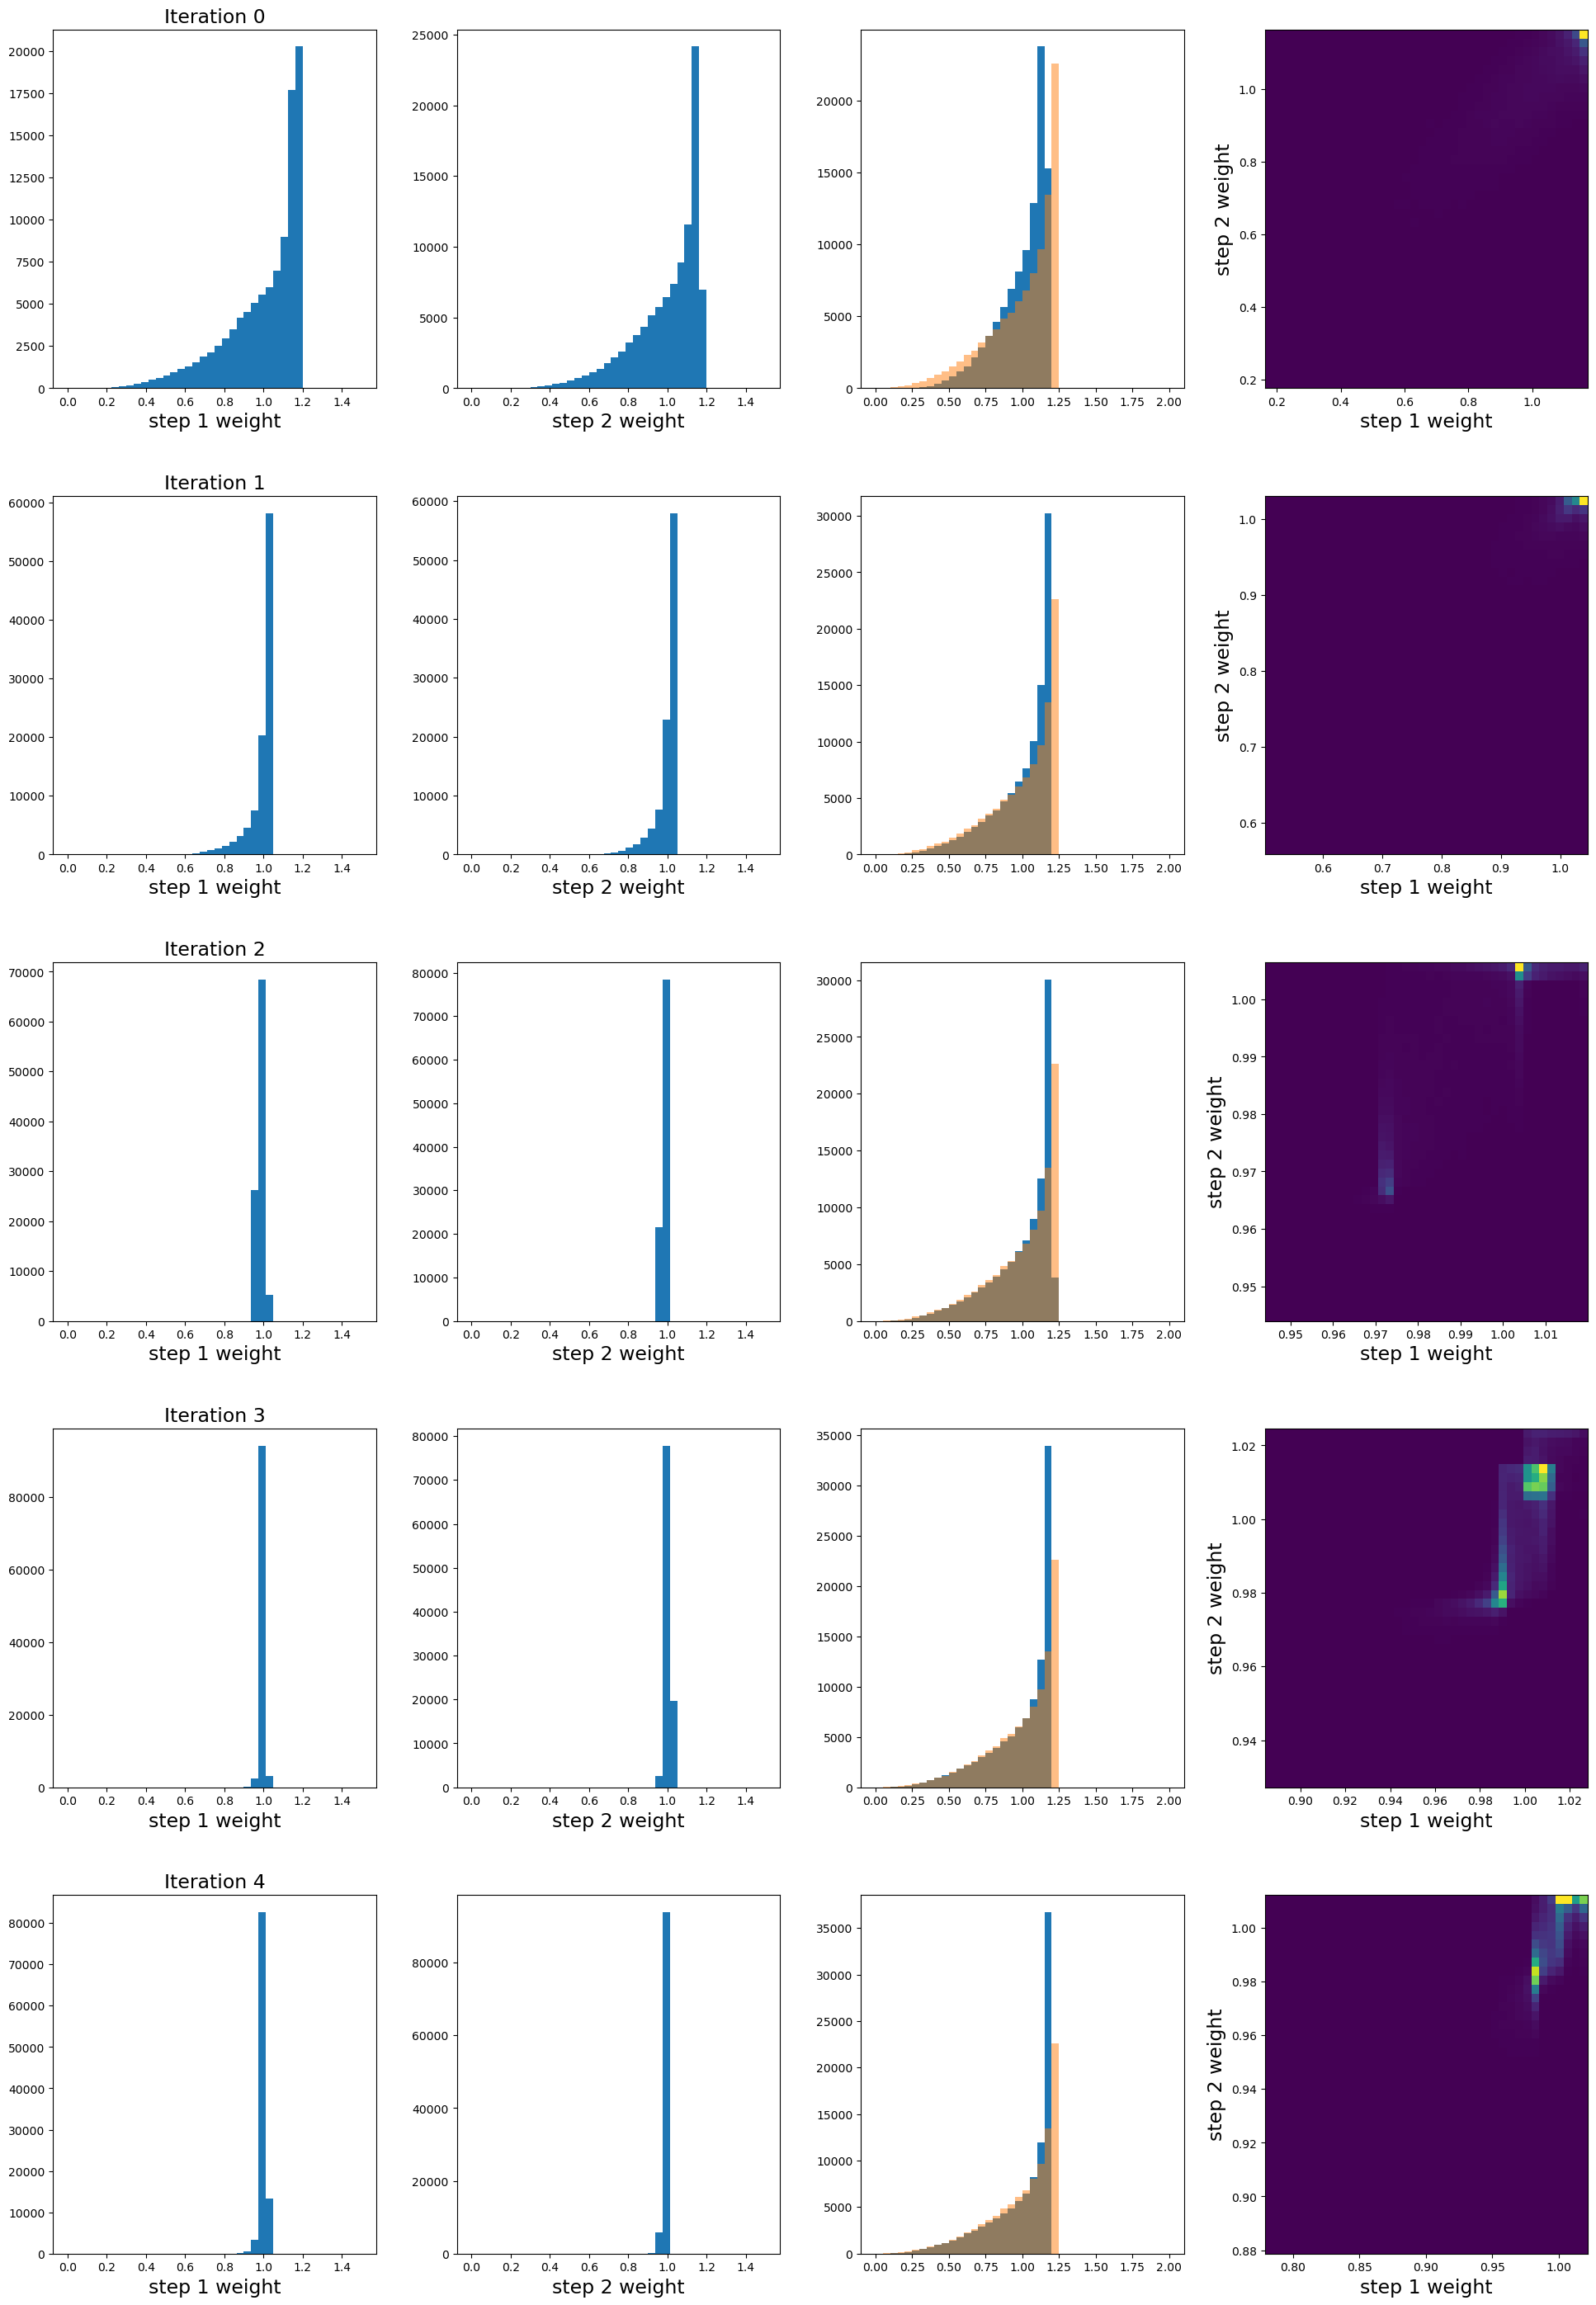

In [39]:
fig,ax = plt.subplots( of_niter, 4, figsize=(24,7*of_niter))

hmin=-6
hmax=6
hbins=40

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

for ofi in range(0,of_niter) :

    ax[ofi][0].hist( of_weights[ofi,0,:], bins=hbins, range=[0.,1.5] )
    
    ax[ofi][1].hist( of_weights[ofi,1,:], bins=hbins, range=[0.,1.5] )
    
    ax[ofi][2].hist( push_weights[ofi,:], bins=hbins, range=[0.,2.] )
    if ndim==1 :
        ax[ofi][2].hist( calc_weight, bins=hbins, range=[0.,2.0], alpha=0.5 )
    
    
    ax[ofi][3].hist2d( of_weights[ofi,0,:], of_weights[ofi,1,:], bins=[hbins,hbins] )
    
    ax[ofi][0].set_xlabel( 'step 1 weight', fontsize=lfontsize )
    
    ax[ofi][1].set_xlabel( 'step 2 weight', fontsize=lfontsize )
    
    ax[ofi][3].set_xlabel( 'step 1 weight', fontsize=lfontsize )
    ax[ofi][3].set_ylabel( 'step 2 weight', fontsize=lfontsize )
    
    ax[ofi][0].set_title('Iteration %d' % ofi, fontsize=lfontsize )
    
    
plt.show

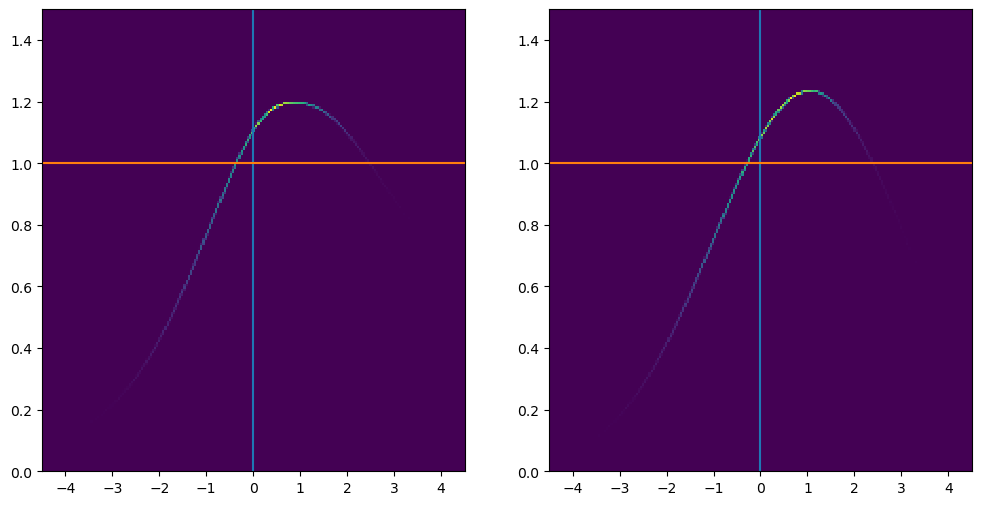

In [40]:
if ndim==1 :
    
    fig,ax = plt.subplots( 1, 2, figsize=(2*6,6))

    hbins=200

    hpw,xe,ye,_ = ax[0].hist2d( mc_pts[:,0], push_weights[-1,:], 
                          bins=[hbins,hbins], range=([-4.5,4.5],[0.,1.5]) )

    hcw,_,_,_ = ax[1].hist2d( mc_pts[:,0], calc_weight, 
                          bins=[hbins,hbins], range=([-4.5,4.5],[0.,1.5]) )

    ax[0].plot([0,0],[0,1.5])
    ax[0].plot([-4.5,4.5],[1,1])

    ax[1].plot([0,0],[0,1.5])
    ax[1].plot([-4.5,4.5],[1,1])

    plt.show

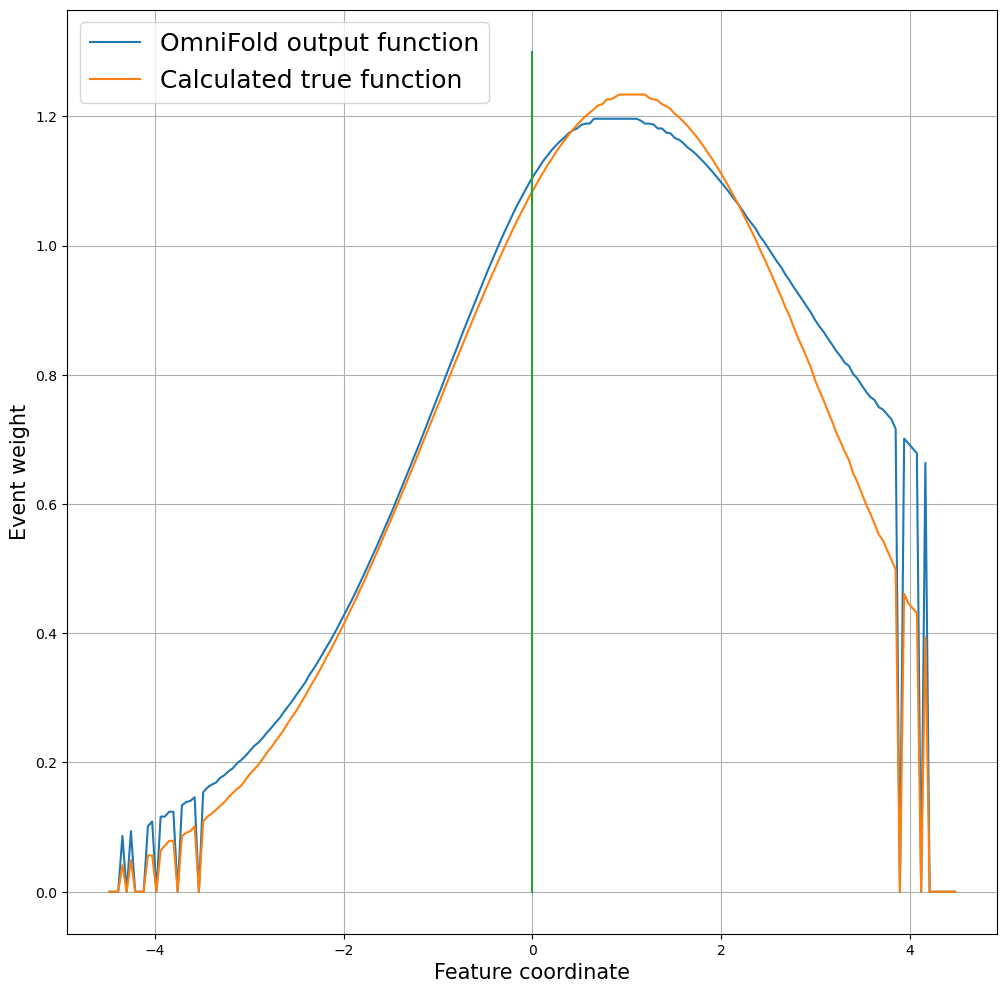

In [41]:
if ndim==1 :
    
    ave_fpw, xvals = hist_to_func( hpw, xe, ye )
    
    calc_pw, xvals = hist_to_func( hcw, xe, ye )
    
    fig,ax = plt.subplots( 1, 1, figsize=(12,12))
    ax.plot(xvals, ave_fpw, label='OmniFold output function')
    ax.plot(xvals, calc_pw, label='Calculated true function')
    ax.plot([0,0],[0,1.3])
    
    ax.legend( fontsize=18 )
    
    ax.grid(True)
    
    ax.set_xlabel('Feature coordinate', fontsize=15)
    ax.set_ylabel('Event weight', fontsize=15)
    
    plt.show
    

<function matplotlib.pyplot.show(close=None, block=None)>

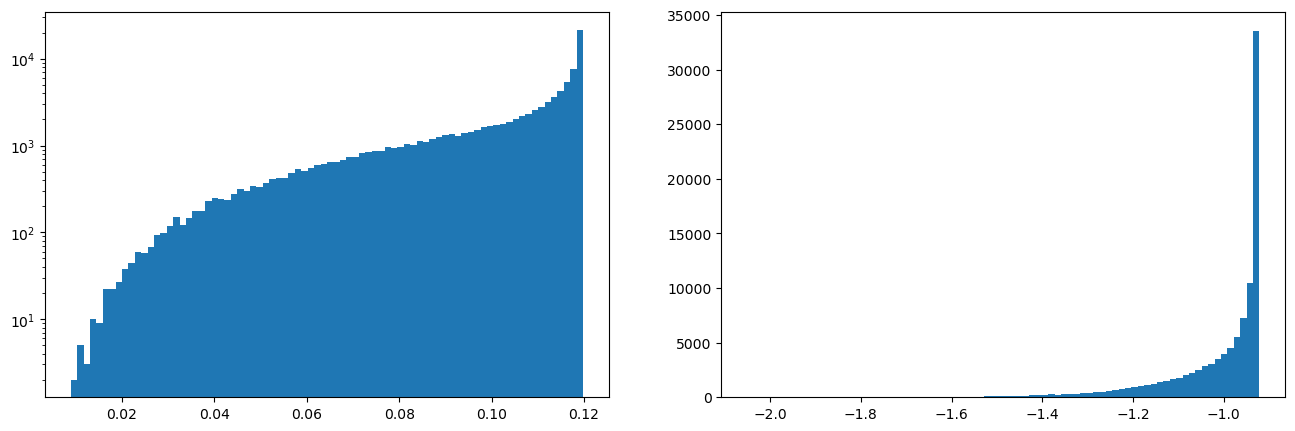

In [42]:
fig,ax = plt.subplots( 1, 2, figsize=(8*2,5))

hbins=80

ax[0].hist( final_push_weights_scaled, bins=hbins)
ax[0].set_yscale('log')

ax[1].hist( np.log10(final_push_weights_scaled), bins=hbins)

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

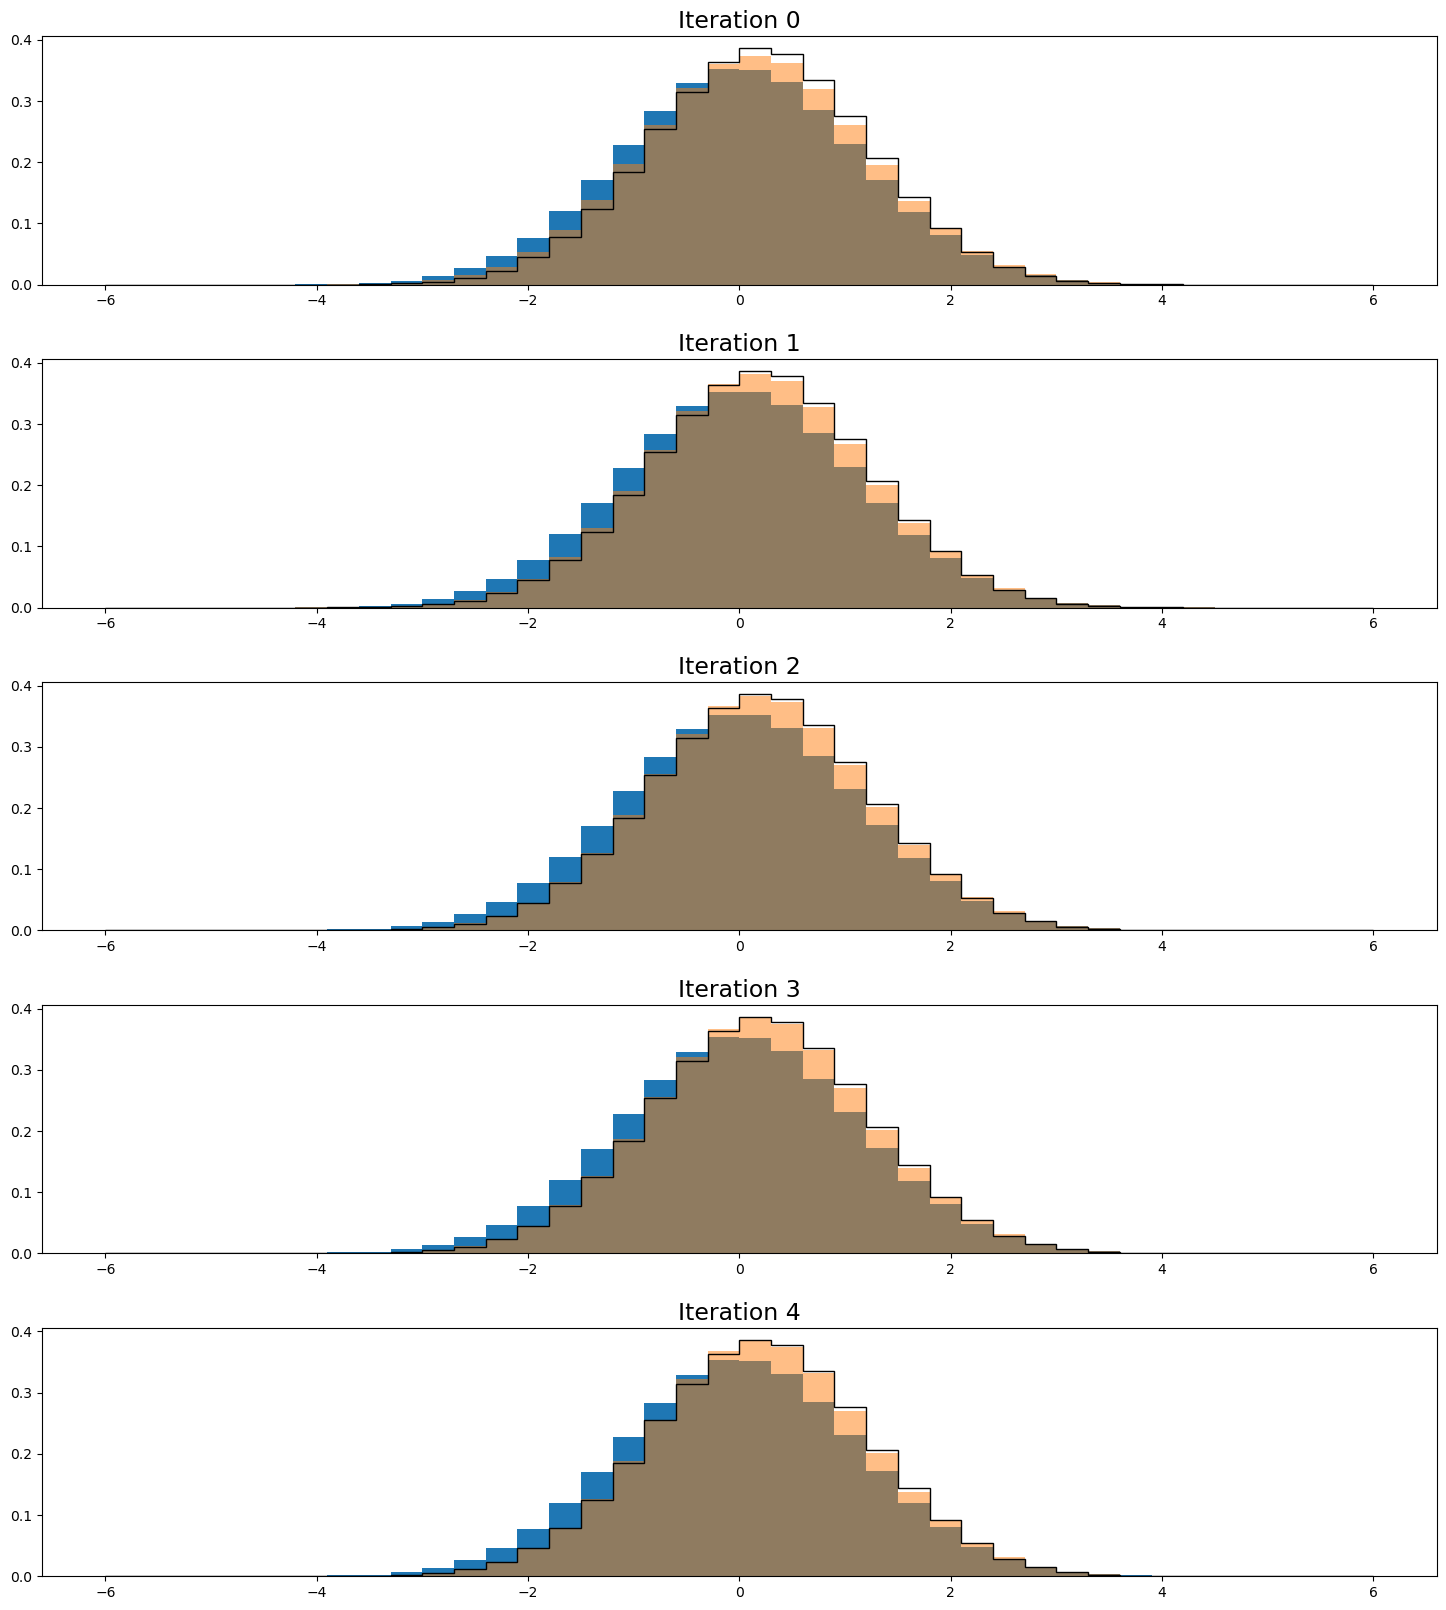

In [43]:


fig,ax = plt.subplots( of_niter, ndim, figsize=(18,4*of_niter))

hmin=-6
hmax=6
hbins=40

det_hist_data_mc_ofweighted = np.zeros( shape=(of_niter,ndim,hbins))
det_hist_data_truth         = np.zeros( shape=(of_niter,ndim,hbins))

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

do_renorm = True


for ofi in range(0,of_niter) :

    if do_renorm :
        
        for di in range(ndim) :
            
            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
            
            thisax.hist( mc_det_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='mc particle' )
            det_hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( mc_det_pts[:,di], weights=push_weights[ofi], bins=hbins, density=True, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            det_hist_data_truth[ofi,di],_,_ =         thisax.hist( true_det_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, density=True, range=[hmin,hmax], label='true particle', histtype='step', color='black' )

    else :
        
        for di in range(ndim) :

            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
        
            det_hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( mc_det_pts[:,di], weights=push_weights_scaled[ofi], bins=hbins, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            det_hist_data_truth[ofi,di],_,_ =         thisax.hist( true_det_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, range=[hmin,hmax], label='true particle', histtype='step', color='black' )
        

    

    
    if ndim > 1 :
        thisax = ax[ofi][0]
    else :
        thisax = ax[ofi]
    
    thisax.set_title('Iteration %d' % ofi, fontsize=lfontsize )



plt.show

In [44]:
det_hist_data_diff = det_hist_data_mc_ofweighted - det_hist_data_truth
det_hist_data_diff2 = det_hist_data_diff * det_hist_data_diff

det_hist_data_sum_diff2 = np.zeros( shape=(of_niter,ndim))

for ofi in range( of_niter ) :
    for di in range( ndim ) :
        det_hist_data_sum_diff2[ofi,di] = np.sum( det_hist_data_diff2[ofi,di])


<function matplotlib.pyplot.show(close=None, block=None)>

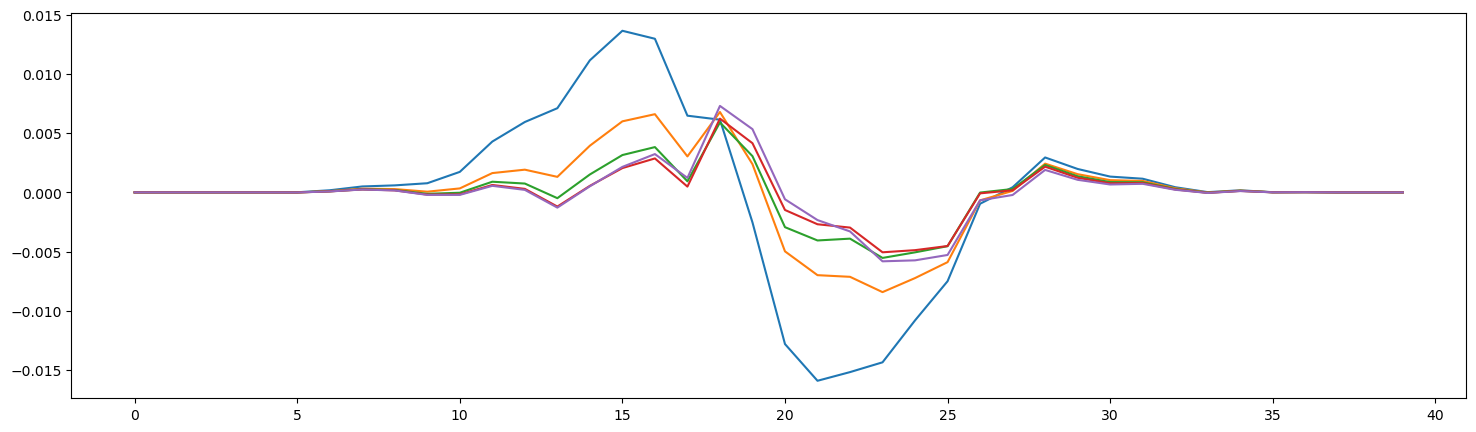

In [45]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

for ofi in range(of_niter) :
    for di in range( ndim ) :
        if ndim == 1 :
            axi = ax
        else :
            axi = ax[di]
        axi.plot(det_hist_data_diff[ofi,di])

    
plt.show   

<function matplotlib.pyplot.show(close=None, block=None)>

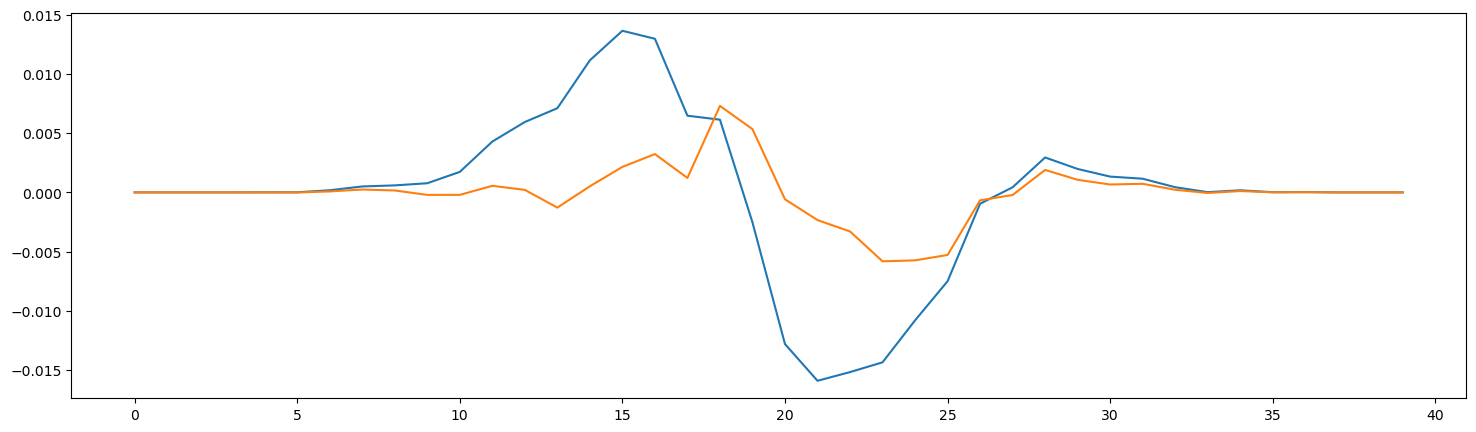

In [46]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

ofi = 0
for di in range( ndim ) :
    if ndim == 1 :
        axi = ax
    else :
        axi = ax[di]
    axi.plot(det_hist_data_diff[ofi,di])

ofi = of_niter-1
for di in range( ndim ) :
    if ndim == 1 :
        axi = ax
    else :
        axi = ax[di]
    axi.plot(det_hist_data_diff[ofi,di])

    
plt.show  

<function matplotlib.pyplot.show(close=None, block=None)>

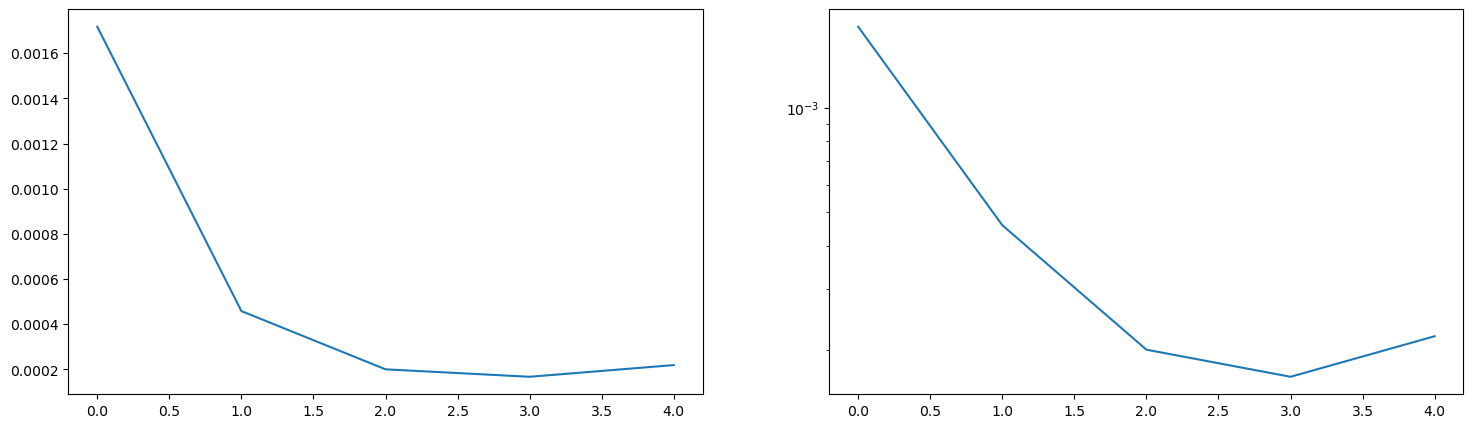

In [47]:
fig,ax = plt.subplots( 1, 2, figsize=(18,5))
ax[0].plot( det_hist_data_sum_diff2)
ax[1].plot( det_hist_data_sum_diff2)
ax[1].set_yscale('log')
plt.show

In [48]:
step1_mean = np.zeros( of_niter )
step1_rms = np.zeros( of_niter )

step2_mean = np.zeros( of_niter )
step2_rms = np.zeros( of_niter )

iter_val = np.zeros( of_niter )

for ofi in range( of_niter ) :
    
    iter_val[ofi] = ofi
    
    step1_mean[ofi] = np.mean( of_weights[ofi,0,:] )
    step1_rms[ofi] = np.sqrt( np.var( of_weights[ofi,0,:]))
    
    step2_mean[ofi] = np.mean( of_weights[ofi,1,:] )
    step2_rms[ofi] = np.sqrt( np.var( of_weights[ofi,1,:]))
    
    print("  iter %2d : step 1 mean  %.3f  rms %.3f      step 2 mean  %.3f  rms %.3f" % 
          (ofi, step1_mean[ofi], step1_rms[ofi], step2_mean[ofi], step2_rms[ofi]) )

  iter  0 : step 1 mean  1.002  rms 0.189      step 2 mean  1.001  rms 0.169
  iter  1 : step 1 mean  0.995  rms 0.069      step 2 mean  0.996  rms 0.054
  iter  2 : step 1 mean  0.992  rms 0.015      step 2 mean  0.992  rms 0.015
  iter  3 : step 1 mean  0.999  rms 0.012      step 2 mean  0.999  rms 0.015
  iter  4 : step 1 mean  0.995  rms 0.015      step 2 mean  0.996  rms 0.014


<function matplotlib.pyplot.show(close=None, block=None)>

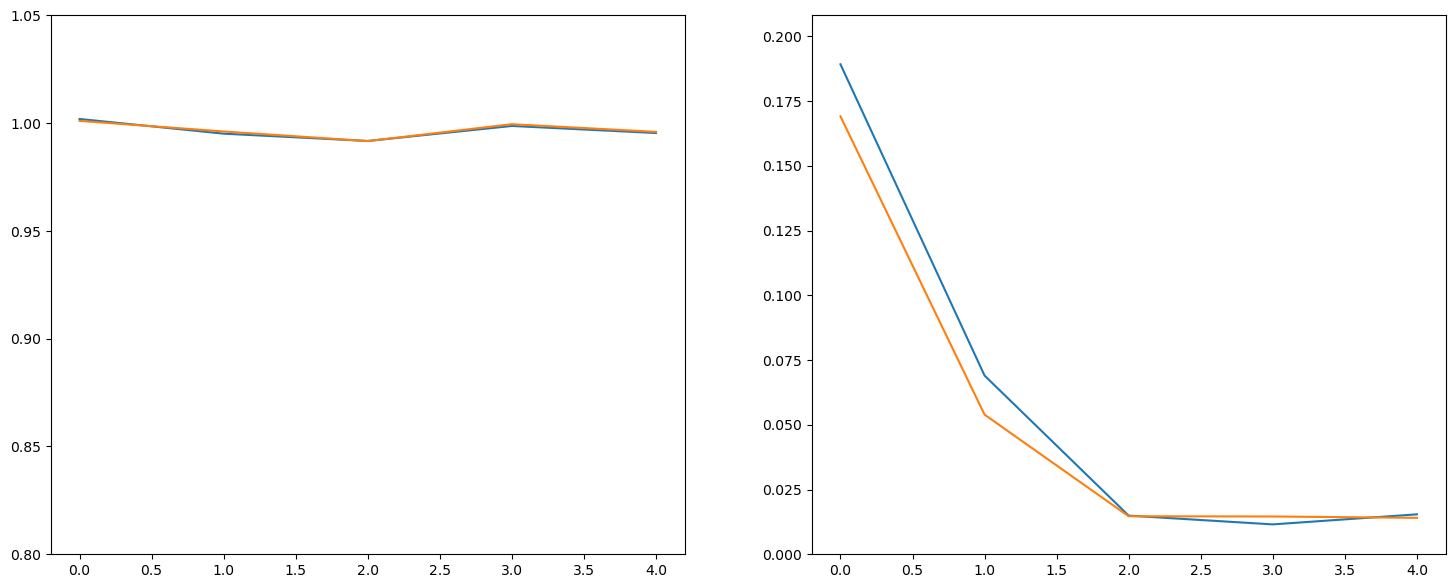

In [49]:
fig,ax = plt.subplots( 1, 2, figsize=(18,7))

ax[0].plot( iter_val, step1_mean )
ax[0].plot( iter_val, step2_mean )
ax[0].set_ylim( 0.80, 1.05)

ax[1].plot( iter_val, step1_rms )
ax[1].plot( iter_val, step2_rms )
ax[1].set_ylim( 0, 1.1*np.max(step1_rms))


plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

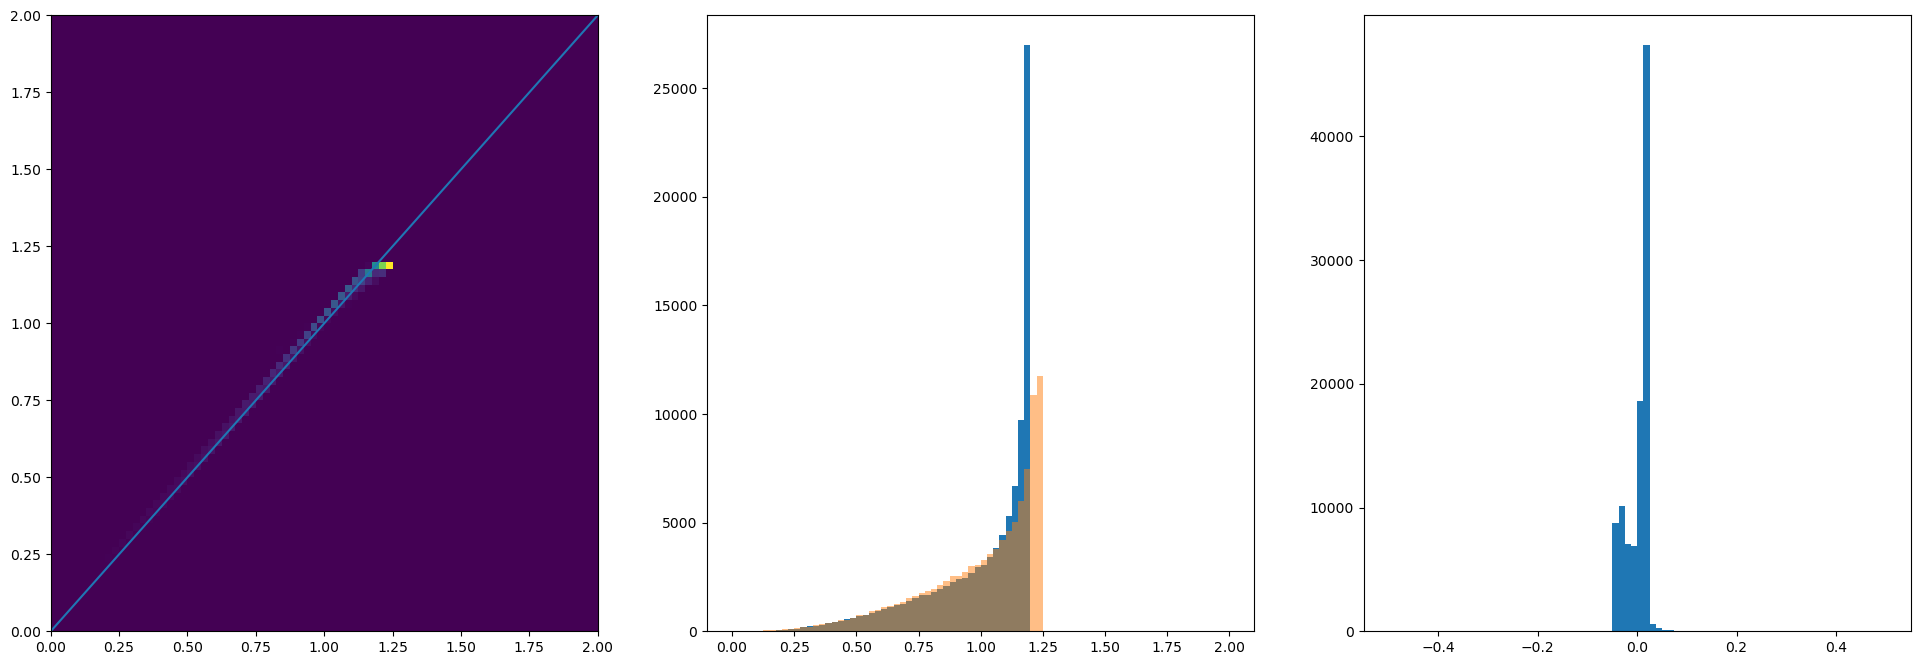

In [50]:
fig,ax = plt.subplots( 1, 3, figsize=(3*8,1*8))
max_weight = 2.0

ax[0].hist2d( calc_weight, final_push_weights, bins=[80,80], range=([0,max_weight],[0,max_weight]))
ax[0].plot([0,max_weight],[0,max_weight])

ax[1].hist( final_push_weights, bins=80, range=[0,max_weight] )
ax[1].hist( calc_weight, bins=80, range=[0,max_weight], alpha=0.5 )

ax[2].hist( final_push_weights-calc_weight, bins=80, range=[-0.5,0.5] )

plt.show

In [51]:
push_weights.shape

(5, 100000)

 Iteration 0:  delta weight  mean   0.0001, RMS   0.0690
 Iteration 1:  delta weight  mean   0.0005, RMS   0.0348
 Iteration 2:  delta weight  mean   0.0005, RMS   0.0224
 Iteration 3:  delta weight  mean  -0.0039, RMS   0.0207
 Iteration 4:  delta weight  mean   0.0030, RMS   0.0227


<function matplotlib.pyplot.show(close=None, block=None)>

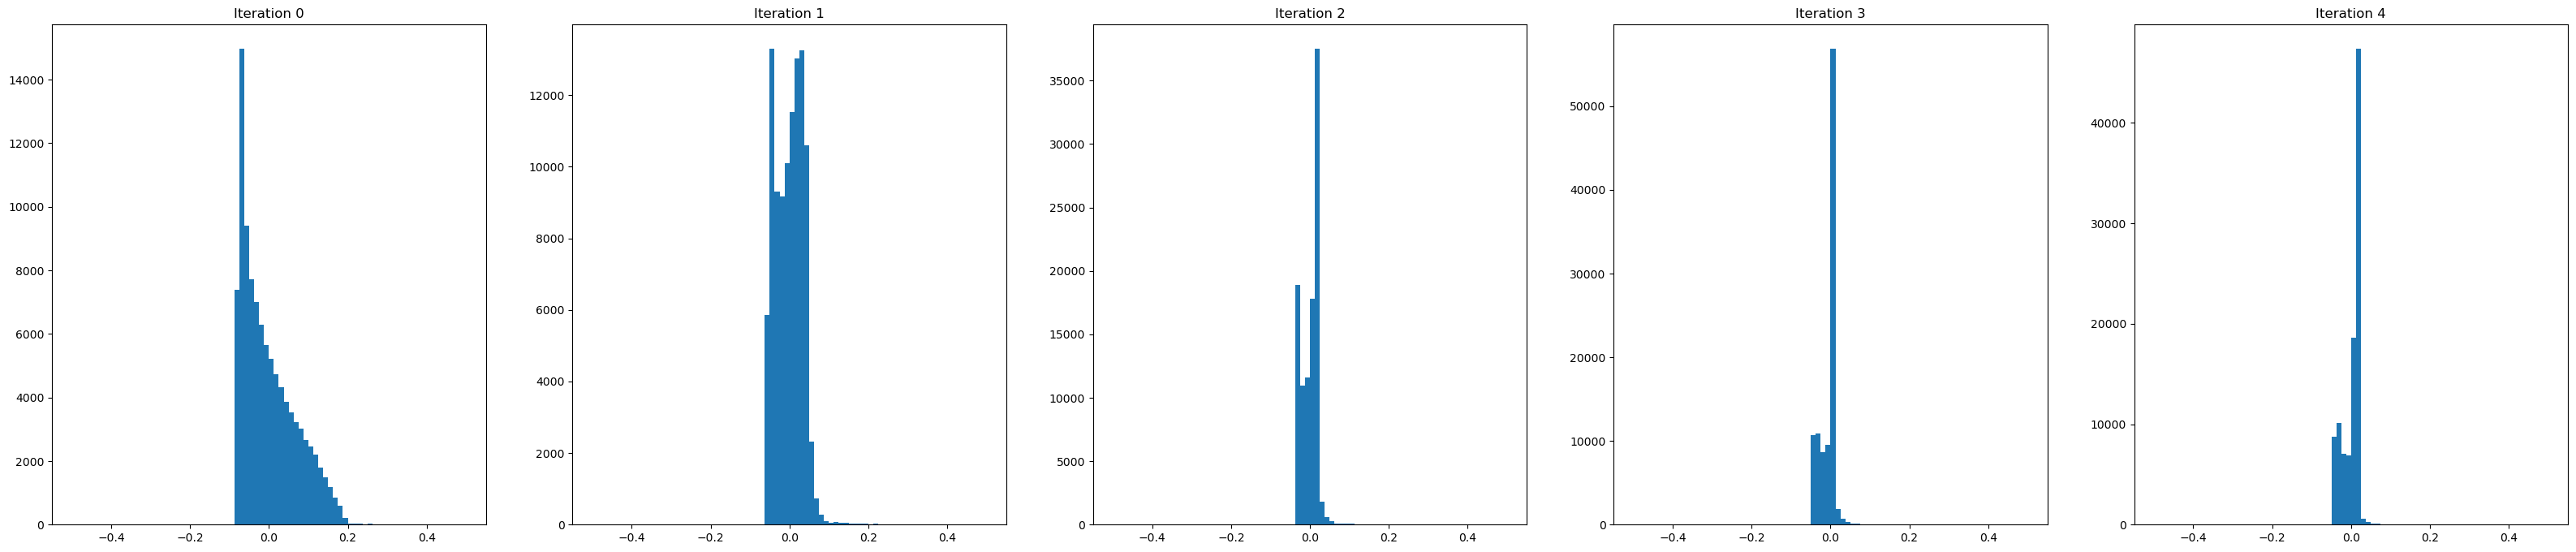

In [52]:
fig,ax = plt.subplots( 1, of_niter, figsize=(of_niter*8,1*8))

dw_mean = np.zeros( shape=(of_niter))
dw_rms = np.zeros( shape=(of_niter))

for i in range( of_niter ) :
    
    axi = ax[i]
    axi.hist( push_weights[i,:]-calc_weight, bins=80, range=[-0.5,0.5] )
    axi.set_title('Iteration %d' % i)
    
    dw_mean[i] = np.mean( push_weights[i,:]-calc_weight )
    dw_rms[i] = np.sqrt( np.cov(push_weights[i,:]-calc_weight))
    print(' Iteration %d:  delta weight  mean %8.4f, RMS %8.4f' % (i, dw_mean[i], dw_rms[i]))
    
plt.show


<function matplotlib.pyplot.show(close=None, block=None)>

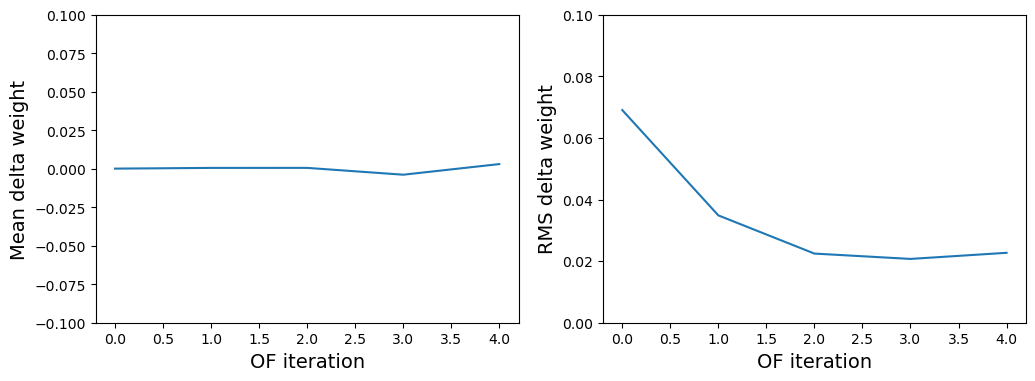

In [53]:
fig,ax = plt.subplots( 1, 2, figsize=(2*6,4))

axi=ax[0]
axi.plot( np.linspace(0,of_niter-1,of_niter), dw_mean )
axi.set_ylim([-0.1,0.1])
axi.set_xlabel('OF iteration', fontsize=14)
axi.set_ylabel('Mean delta weight', fontsize=14)

axi=ax[1]
axi.plot( np.linspace(0,of_niter-1,of_niter), dw_rms)
axi.set_ylim([0.0,0.1])
axi.set_xlabel('OF iteration', fontsize=14)
axi.set_ylabel('RMS delta weight', fontsize=14)


plt.show

In [54]:
def profile2d( axis, xvals, yvals, hbins, hrange, drawhist=True, drawline=False, drawcurve=True ) :
    
    hist_data = axis.hist2d( xvals, yvals, bins=hbins, range=hrange)
    
    if not drawhist :
        axis.cla()

    nybins = len(hist_data[0][0])
    #print("number of y bins: %d" % nybins)

    nxbins = len(hist_data[0])
    #print("number of x bins: %d" % nxbins)



    x_vals = np.zeros( nxbins )
    avey_vals = np.zeros( nxbins )
    rmsy_vals = np.zeros( nxbins )

    for xbi in range( nxbins ) :

        wsum = 0
        ywsum = 0
        yywsum = 0

        xval = 0.5 * ( hist_data[1][xbi] + hist_data[1][xbi+1] )
        #print(" xbin %d has center at %6.3f" % ( xbin_ind, xval ))

        for ybi in range( nybins ) :  
            yval = 0.5 * ( hist_data[2][ybi] + hist_data[2][ybi+1] )
            bin_content = hist_data[0][xbi][ybi]
            wsum = wsum + bin_content
            ywsum = ywsum + yval * bin_content
            yywsum = yywsum + yval * yval * bin_content
            #print("  %3d : y = %6.3f  bin content = %7d" % (bi, yval, bin_content))

        ave_y = ywsum / wsum
        ave_yy = yywsum / wsum
        rms_y = ave_yy - ave_y * ave_y
        #print(" Ave y = %.3f, RMS y = %.3f" % ( ave_y, rms_y) )

        x_vals[xbi] = xval
        avey_vals[xbi] = ave_y
        rmsy_vals[xbi] = rms_y


    #for xbi in range( nxbins ) :
        #print("  %4d :  x = %7.3f   ave y = %7.3f  rms y = %7.3f" % ( xbi, x_vals[xbi], avey_vals[xbi], rmsy_vals[xbi]))

    if drawline :
        axis.plot( (hist_data[1][0], hist_data[1][-1]), (0,0) )  
    
    if drawcurve :
        axis.errorbar( x_vals, avey_vals, yerr=rmsy_vals, fmt='-', linewidth=5)

    
    plt.show
    
    return x_vals, avey_vals, rmsy_vals

In [55]:
ensemble_of_prob = of_return_dict['ensemble_weights'] / (1. + of_return_dict['ensemble_weights'])
ave_ensemble_of_prob = np.average( ensemble_of_prob, axis=0 )

In [56]:
ensemble_of_prob.shape

(10, 5, 2, 100000)

In [57]:
ensemble_of_prob[0,0,0,:]

array([0.53445763, 0.47591497, 0.39208657, ..., 0.53501587, 0.53093518,
       0.48906618])

 OF iter 0, step 0 .

/tmp/ipykernel_2843797/2705709498.py:37: RuntimeWarning: invalid value encountered in scalar divide
  ave_y = ywsum / wsum
/tmp/ipykernel_2843797/2705709498.py:38: RuntimeWarning: invalid value encountered in scalar divide
  ave_yy = yywsum / wsum


.........
 OF iter 0, step 1 .

/tmp/ipykernel_2843797/2705709498.py:37: RuntimeWarning: invalid value encountered in scalar divide
  ave_y = ywsum / wsum
/tmp/ipykernel_2843797/2705709498.py:38: RuntimeWarning: invalid value encountered in scalar divide
  ave_yy = yywsum / wsum


.........
 OF iter 1, step 0 .

/tmp/ipykernel_2843797/2705709498.py:37: RuntimeWarning: invalid value encountered in scalar divide
  ave_y = ywsum / wsum
/tmp/ipykernel_2843797/2705709498.py:38: RuntimeWarning: invalid value encountered in scalar divide
  ave_yy = yywsum / wsum


.........
 OF iter 1, step 1 .

/tmp/ipykernel_2843797/2705709498.py:37: RuntimeWarning: invalid value encountered in scalar divide
  ave_y = ywsum / wsum
/tmp/ipykernel_2843797/2705709498.py:38: RuntimeWarning: invalid value encountered in scalar divide
  ave_yy = yywsum / wsum


.........
 OF iter 2, step 0 .

/tmp/ipykernel_2843797/2705709498.py:37: RuntimeWarning: invalid value encountered in scalar divide
  ave_y = ywsum / wsum
/tmp/ipykernel_2843797/2705709498.py:38: RuntimeWarning: invalid value encountered in scalar divide
  ave_yy = yywsum / wsum


.........
 OF iter 2, step 1 .

/tmp/ipykernel_2843797/2705709498.py:37: RuntimeWarning: invalid value encountered in scalar divide
  ave_y = ywsum / wsum
/tmp/ipykernel_2843797/2705709498.py:38: RuntimeWarning: invalid value encountered in scalar divide
  ave_yy = yywsum / wsum


.........
 OF iter 3, step 0 .

/tmp/ipykernel_2843797/2705709498.py:37: RuntimeWarning: invalid value encountered in scalar divide
  ave_y = ywsum / wsum
/tmp/ipykernel_2843797/2705709498.py:38: RuntimeWarning: invalid value encountered in scalar divide
  ave_yy = yywsum / wsum


.........
 OF iter 3, step 1 .

/tmp/ipykernel_2843797/2705709498.py:37: RuntimeWarning: invalid value encountered in scalar divide
  ave_y = ywsum / wsum
/tmp/ipykernel_2843797/2705709498.py:38: RuntimeWarning: invalid value encountered in scalar divide
  ave_yy = yywsum / wsum


.........
 OF iter 4, step 0 .

/tmp/ipykernel_2843797/2705709498.py:37: RuntimeWarning: invalid value encountered in scalar divide
  ave_y = ywsum / wsum
/tmp/ipykernel_2843797/2705709498.py:38: RuntimeWarning: invalid value encountered in scalar divide
  ave_yy = yywsum / wsum


.........
 OF iter 4, step 1 .

/tmp/ipykernel_2843797/2705709498.py:37: RuntimeWarning: invalid value encountered in scalar divide
  ave_y = ywsum / wsum
/tmp/ipykernel_2843797/2705709498.py:38: RuntimeWarning: invalid value encountered in scalar divide
  ave_yy = yywsum / wsum


.........


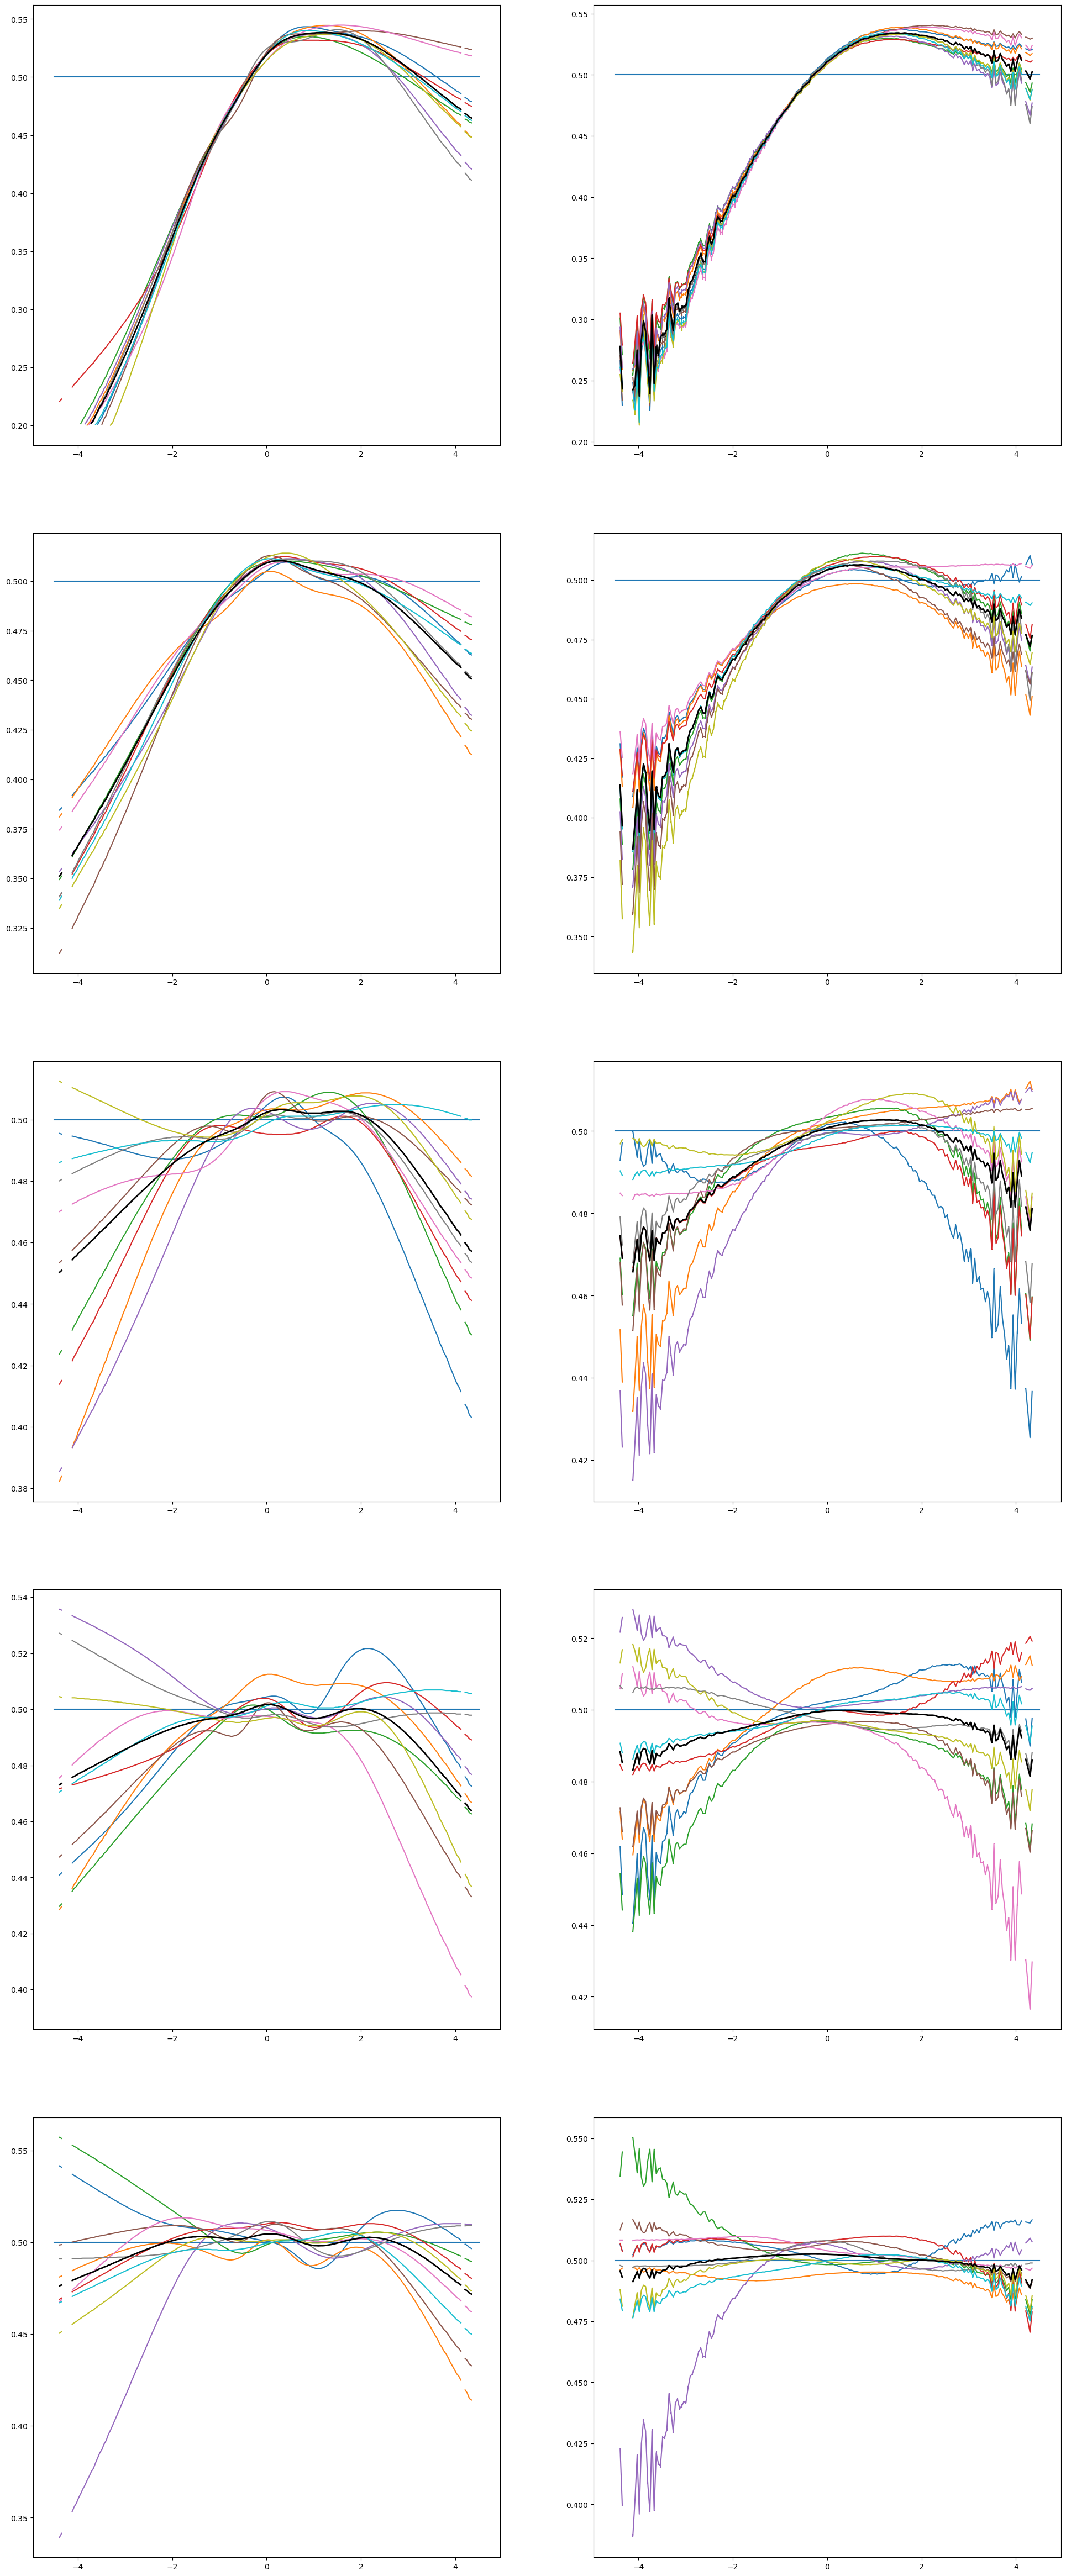

In [58]:
if ndim==1 :
    
    fig,ax = plt.subplots( of_niter, 2, figsize=(2*12,of_niter*12))

    xmin = -4.5
    xmax = 4.5

    ymin = 0.2
    ymax = 0.6

    x = np.zeros(shape=(n_models_to_ensemble,200))
    y = np.zeros(shape=(n_models_to_ensemble,200))
    e = np.zeros(shape=(n_models_to_ensemble,200))


    for ofi in range( of_niter ) :

        for si in range( 2 ) :

            print(' OF iter %d, step %d ' % (ofi,si), end='')

            axi = ax[ofi,si]

            for ei in range(n_models_to_ensemble) :
                print('.', end='')
                x[ei,:],y[ei,:],e[ei,:] = profile2d( axi, mc_det_pts[:,0], ensemble_of_prob[ei,ofi,si,:], 
                  hbins=[200,2000], hrange=([xmin,xmax],[ymin,ymax]), drawhist=False, drawline=False, drawcurve=False ) 

            eax, eay, eae = profile2d( axi, mc_det_pts[:,0], ave_ensemble_of_prob[ofi,si,:], 
                  hbins=[200,2000], hrange=([xmin,xmax],[ymin,ymax]), drawhist=False, drawline=False, drawcurve=False )


            for ei in range(n_models_to_ensemble) :
                axi.errorbar( x[ei,:], y[ei,:], e[ei,:])

            axi.errorbar( eax, eay, eae, color='black', linewidth=2 )

            axi.plot([xmin,xmax],[0.5,0.5])



            print()


    plt.show


In [59]:
def prob_from_hists( points_a, points_b, weights_a, weights_b, hnbins, hxmin, hxmax ) :
    
    hbw = (hxmax-hxmin)/hnbins
    
    #-- calculate bin indices
    bin_indices_a = np.array( (points_a - hxmin)/hbw, dtype=int )
    bin_indices_b = np.array( (points_b - hxmin)/hbw, dtype=int )
    
    
    hist_binsum_a = np.zeros( hnbins )
    hist_binsum_b = np.zeros( hnbins )
    
    hist_err_a = np.zeros( hnbins )
    hist_err_b = np.zeros( hnbins )
    
    hist_ratio = np.zeros( hnbins )
    hist_ratio_err = np.zeros( hnbins )
    
    sample_wsum_a = np.sum(weights_a)
    sample_wsum_b = np.sum(weights_b)

    
    for bi in range( hnbins ) :
        hist_binsum_a[bi] = np.sum( weights_a[ bin_indices_a == bi ] ) / sample_wsum_a
        hist_binsum_b[bi] = np.sum( weights_b[ bin_indices_b == bi ] ) / sample_wsum_b
        hist_err_a[bi] = np.sqrt( np.sum( np.square( weights_a[ bin_indices_a == bi ] ) ) ) / sample_wsum_a
        hist_err_b[bi] = np.sqrt( np.sum( np.square( weights_b[ bin_indices_b == bi ] ) ) ) / sample_wsum_b
        if hist_binsum_b[bi] > 0 :
            hist_ratio[bi] = hist_binsum_b[bi] / (hist_binsum_a[bi] + hist_binsum_b[bi])
            if hist_binsum_a[bi] > 0 :
                hist_ratio_err[bi] = np.sqrt(
                    np.square( (hist_binsum_b[bi]/np.square(hist_binsum_b[bi]+hist_binsum_a[bi])) * hist_err_a[bi] ) +
                    np.square( (hist_binsum_a[bi]/np.square(hist_binsum_b[bi]+hist_binsum_a[bi])) * hist_err_b[bi] )
                )
        
    return_dict = {}
    return_dict['hist_binsum_a'] = hist_binsum_a
    return_dict['hist_binsum_b'] = hist_binsum_b
    return_dict['hist_err_a'] = hist_err_a
    return_dict['hist_err_b'] = hist_err_b
    return_dict['hist_ratio'] = hist_ratio
    return_dict['hist_ratio_err'] = hist_ratio_err
    
    return return_dict
    

## Examine the Likelihood Ratio output for Step 1 in OmniFold for each iteration

/tmp/ipykernel_2843797/2705709498.py:37: RuntimeWarning: invalid value encountered in scalar divide
  ave_y = ywsum / wsum
/tmp/ipykernel_2843797/2705709498.py:38: RuntimeWarning: invalid value encountered in scalar divide
  ave_yy = yywsum / wsum
/tmp/ipykernel_2843797/2705709498.py:37: RuntimeWarning: invalid value encountered in scalar divide
  ave_y = ywsum / wsum
/tmp/ipykernel_2843797/2705709498.py:38: RuntimeWarning: invalid value encountered in scalar divide
  ave_yy = yywsum / wsum
/tmp/ipykernel_2843797/2705709498.py:37: RuntimeWarning: invalid value encountered in scalar divide
  ave_y = ywsum / wsum
/tmp/ipykernel_2843797/2705709498.py:38: RuntimeWarning: invalid value encountered in scalar divide
  ave_yy = yywsum / wsum
/tmp/ipykernel_2843797/2705709498.py:37: RuntimeWarning: invalid value encountered in scalar divide
  ave_y = ywsum / wsum
/tmp/ipykernel_2843797/2705709498.py:38: RuntimeWarning: invalid value encountered in scalar divide
  ave_yy = yywsum / wsum
/tmp/ipy

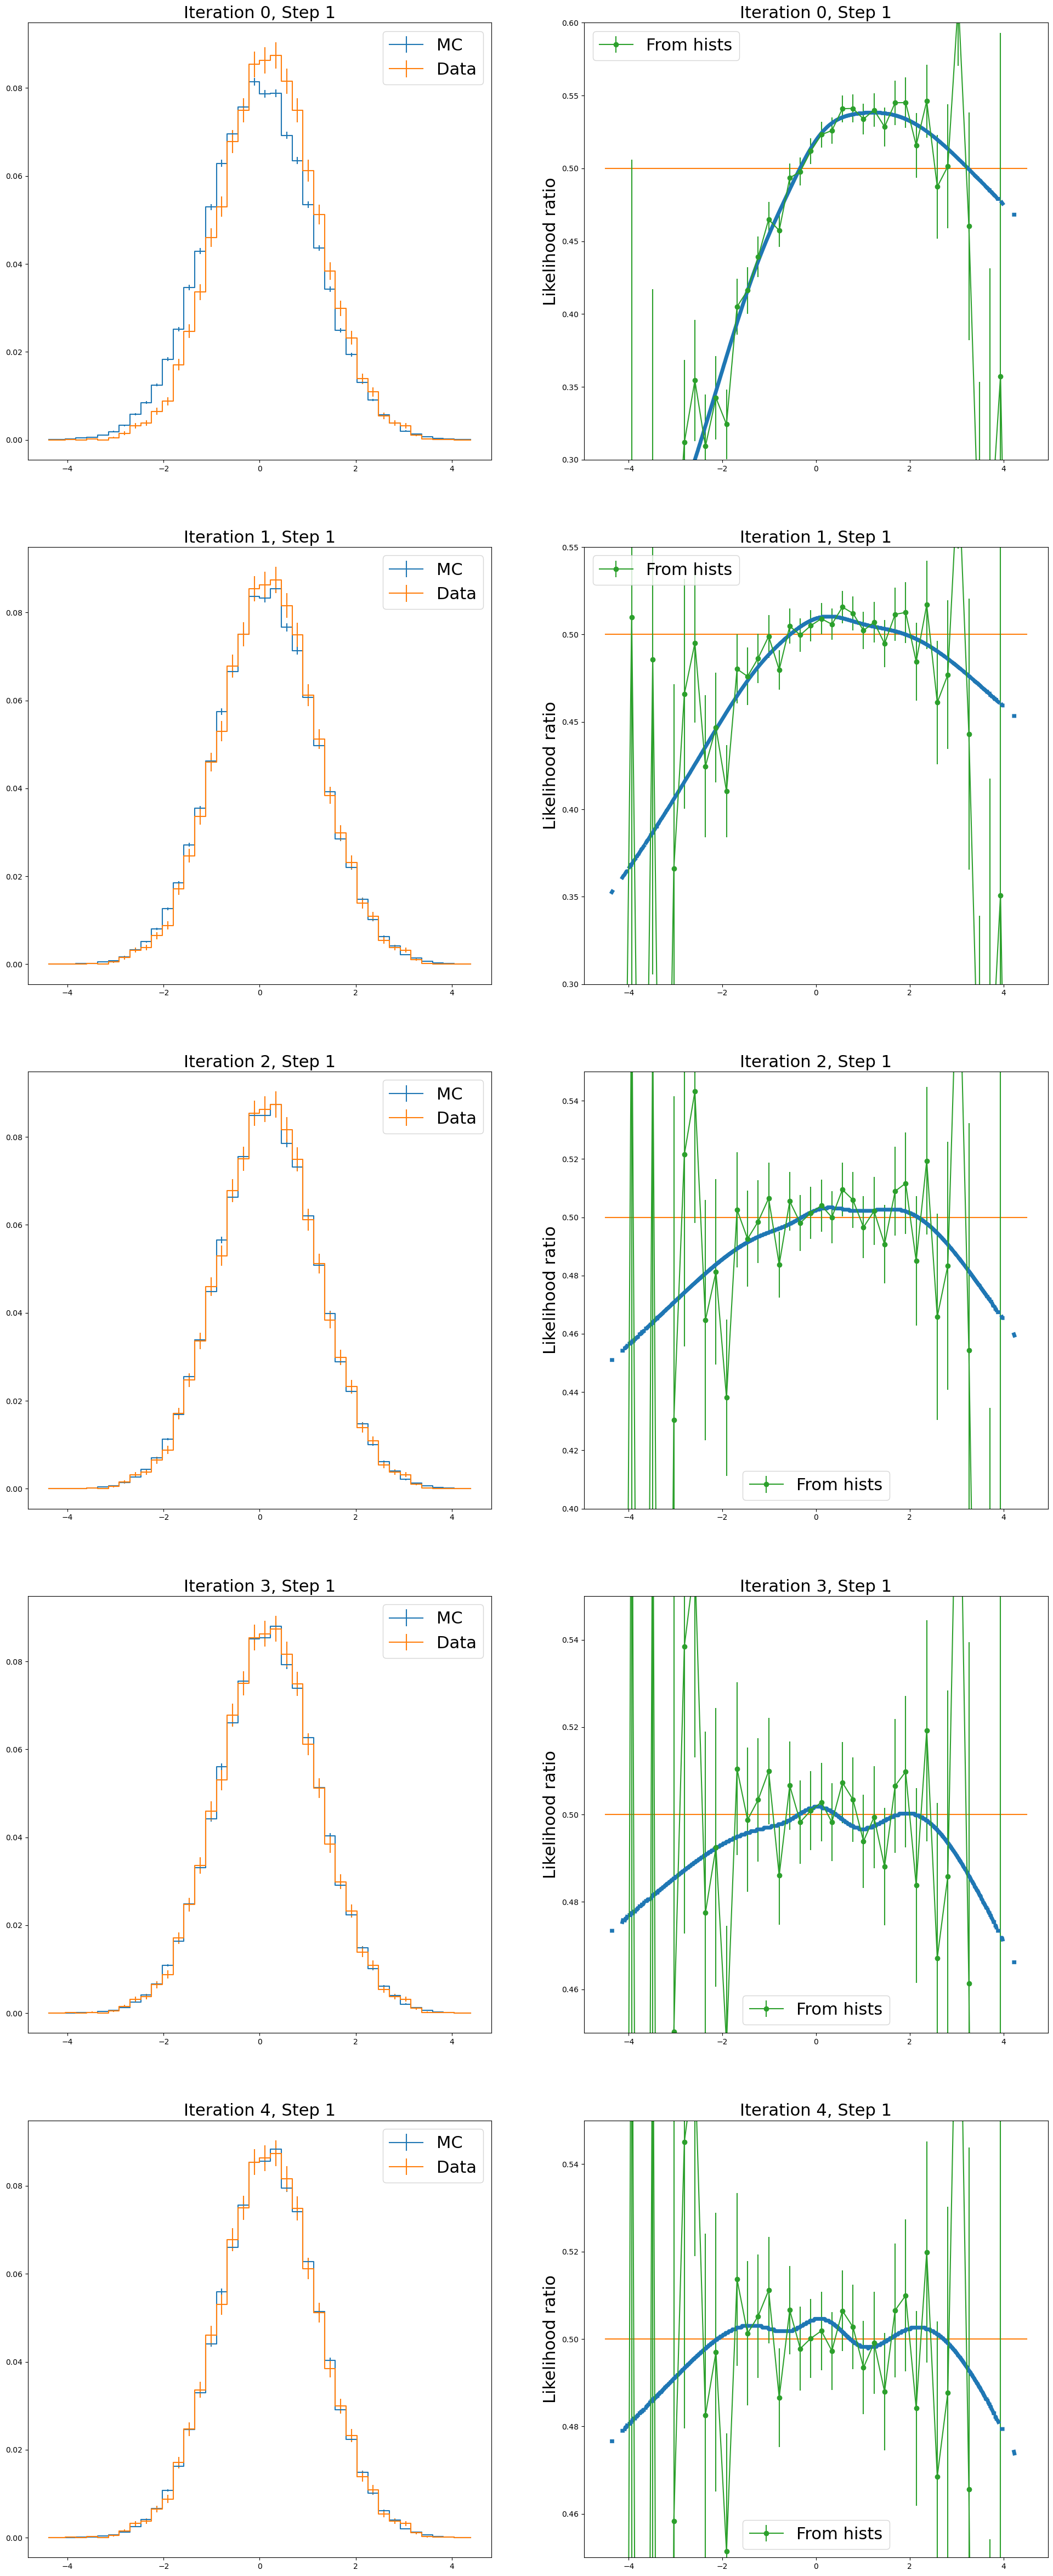

In [60]:

if ndim==1 :

    hxmin = -4.5
    hxmax = 4.5


    hnbins = 40



    hbw = (hxmax-hxmin) / hnbins

    xvals = np.zeros( hnbins )
    for bi in range( hnbins ) :
        xvals[bi] = hxmin + (0.5 + bi)*hbw

    nnbins = 1000

    plotymin=[0.30, 0.30, 0.40, 0.45, 0.45]
    plotymax=[0.60, 0.55, 0.55, 0.55, 0.55]





    fig,ax = plt.subplots( of_niter, 2, figsize=(2*12,of_niter*12))


    for ofi in range( of_niter ) :

        weights_ones_b = np.ones( len(true_det_pts[:,0]) )

        if ofi==0 :        
            weights_a = np.ones( len(mc_det_pts[:,0]) )        
        else :
            weights_a = of_return_dict['push_weights'][ofi-1]

        rd = prob_from_hists( mc_det_pts[:,0], 
                                 true_det_pts[:,0], 
                                 weights_a, 
                                 weights_ones_b, 
                                 hnbins, hxmin, hxmax )

        axi = ax[ofi][0]
        axi.errorbar( xvals, rd['hist_binsum_a'], rd['hist_err_a'], drawstyle='steps-mid', label='MC')
        axi.errorbar( xvals, rd['hist_binsum_b'], rd['hist_err_b'], drawstyle='steps-mid', label='Data')
        axi.legend( fontsize=22 )
        axi.set_title('Iteration %d, Step 1' % ofi, fontsize=22 )

        axi = ax[ofi][1]
        profile2d( axi, mc_det_pts[:,0], ave_ensemble_of_prob[ofi,0,:], 
              hbins=[nnbins,nnbins], hrange=([xmin,xmax],[ymin,ymax]), drawhist=False, drawline=False ) 
        axi.plot([hxmin,hxmax],[0.5,0.5])
        axi.errorbar(xvals,rd['hist_ratio'],rd['hist_ratio_err'], marker='o', linestyle='-', label='From hists')
        axi.legend( fontsize=22 )
        axi.set_ylabel('Likelihood ratio', fontsize=22 )

        axi.set_ylim( plotymin[ofi], plotymax[ofi] )
        axi.set_title('Iteration %d, Step 1' % ofi, fontsize=22 )




    plt.show

/tmp/ipykernel_2843797/2705709498.py:37: RuntimeWarning: invalid value encountered in scalar divide
  ave_y = ywsum / wsum
/tmp/ipykernel_2843797/2705709498.py:38: RuntimeWarning: invalid value encountered in scalar divide
  ave_yy = yywsum / wsum
/tmp/ipykernel_2843797/2705709498.py:37: RuntimeWarning: invalid value encountered in scalar divide
  ave_y = ywsum / wsum
/tmp/ipykernel_2843797/2705709498.py:38: RuntimeWarning: invalid value encountered in scalar divide
  ave_yy = yywsum / wsum
/tmp/ipykernel_2843797/2705709498.py:37: RuntimeWarning: invalid value encountered in scalar divide
  ave_y = ywsum / wsum
/tmp/ipykernel_2843797/2705709498.py:38: RuntimeWarning: invalid value encountered in scalar divide
  ave_yy = yywsum / wsum
/tmp/ipykernel_2843797/2705709498.py:37: RuntimeWarning: invalid value encountered in scalar divide
  ave_y = ywsum / wsum
/tmp/ipykernel_2843797/2705709498.py:38: RuntimeWarning: invalid value encountered in scalar divide
  ave_yy = yywsum / wsum
/tmp/ipy

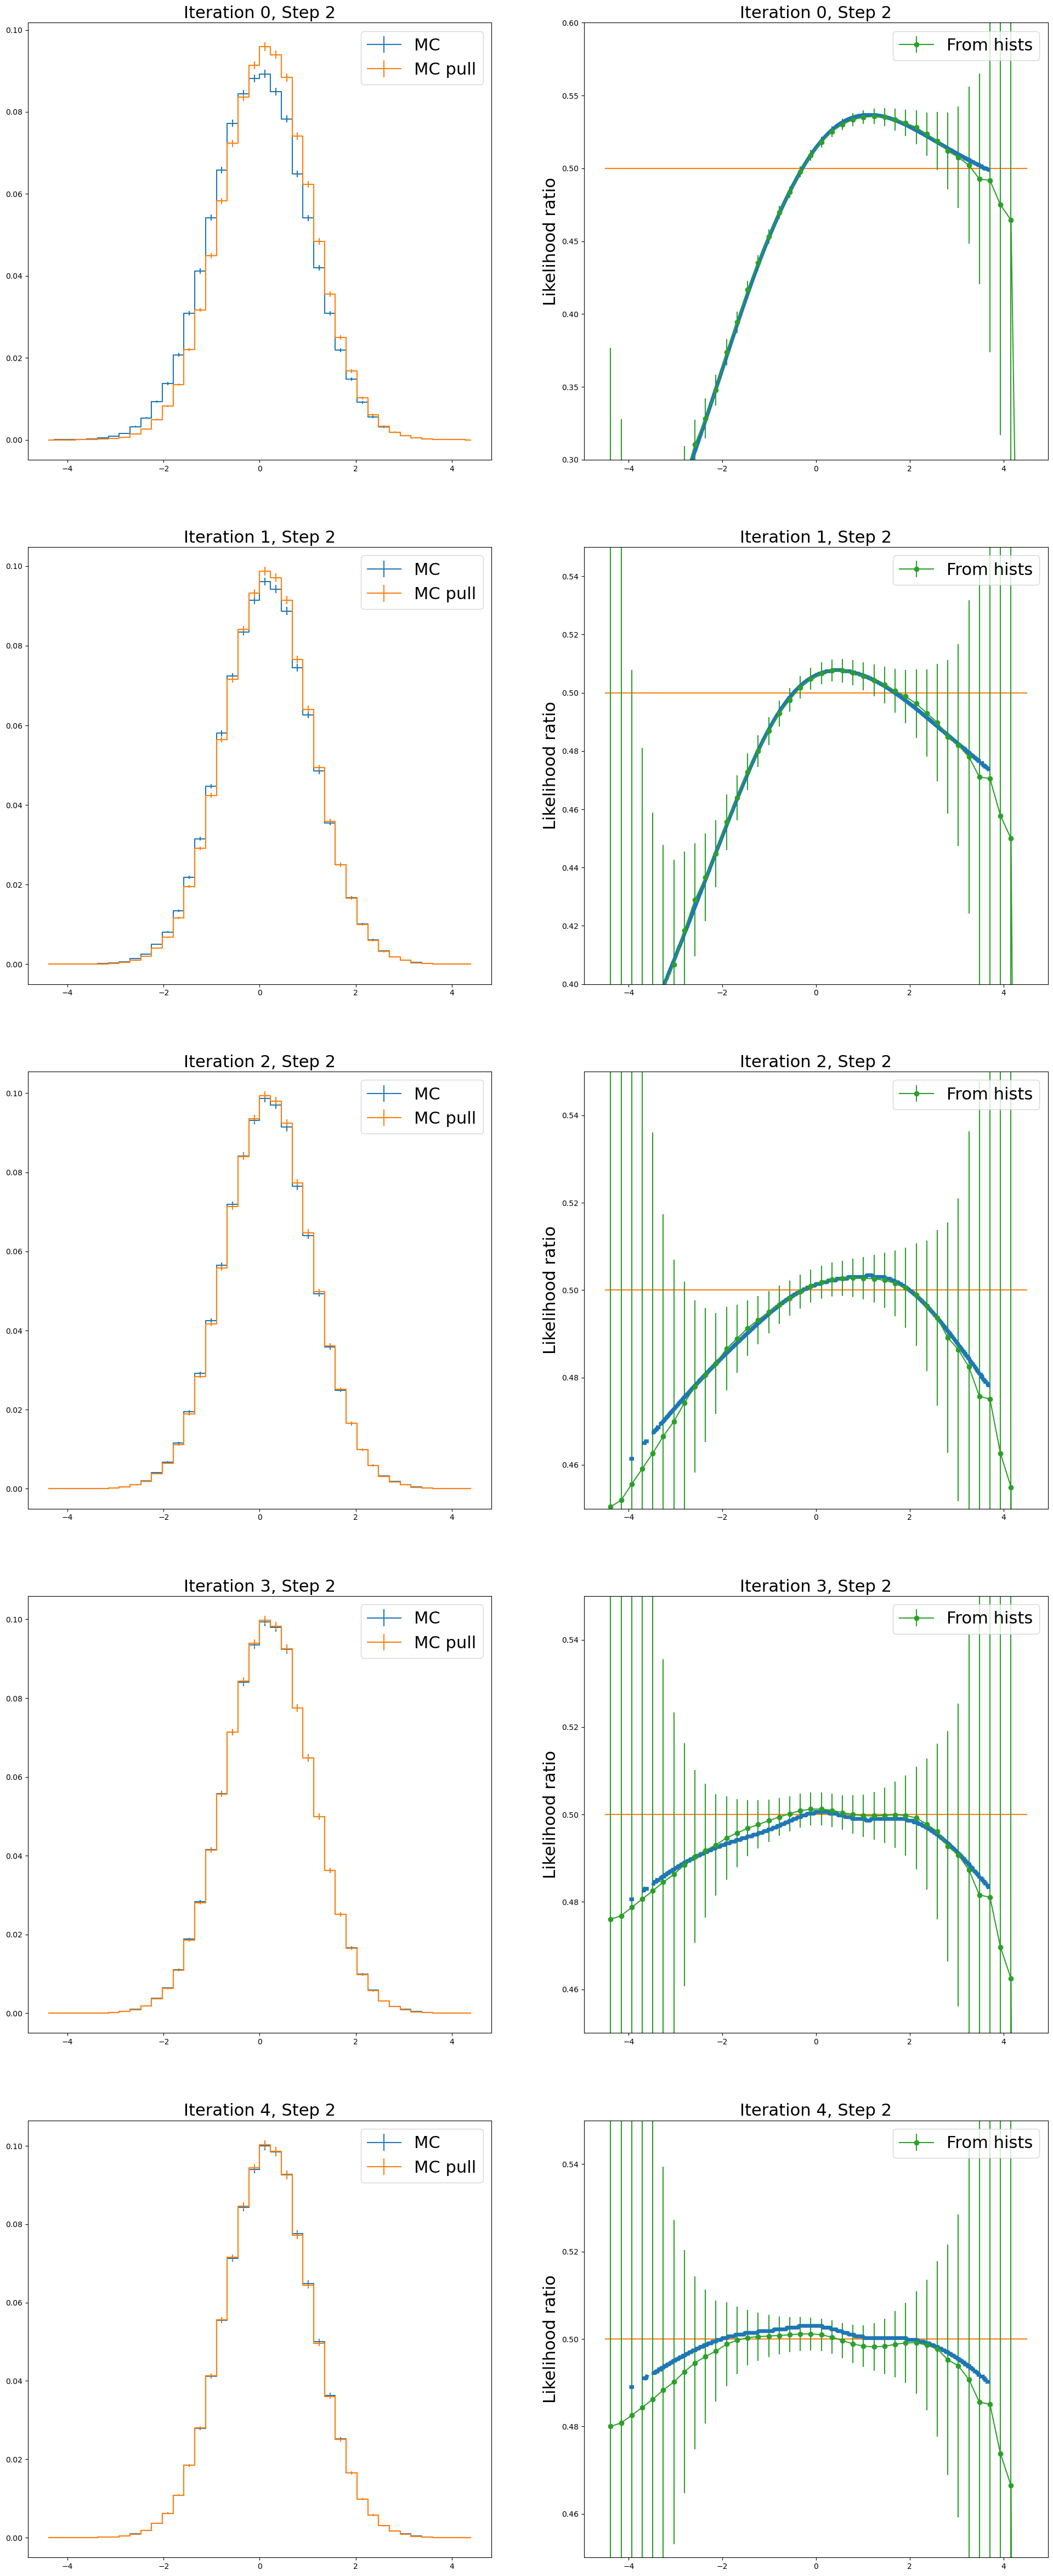

In [61]:

if ndim==1 :

    hxmin = -4.5
    hxmax = 4.5


    hnbins = 40



    hbw = (hxmax-hxmin) / hnbins

    xvals = np.zeros( hnbins )
    for bi in range( hnbins ) :
        xvals[bi] = hxmin + (0.5 + bi)*hbw

    nnbins = 1000

    plotymin=[0.30, 0.40, 0.45, 0.45, 0.45]
    plotymax=[0.60, 0.55, 0.55, 0.55, 0.55]






    fig,ax = plt.subplots( of_niter, 2, figsize=(2*12,of_niter*12))


    for ofi in range( of_niter ) :

        previous_push_weights = np.ones( len(mc_pts[:,0]))
        if ofi > 0 :
            previous_push_weights = of_return_dict['push_weights'][ofi-1]

        #pull_weights = previous_push_weights * of_return_dict['weights'][ofi,0,:]



        rd = prob_from_hists( mc_pts[:,0], 
                                 mc_pts[:,0], 
                                 previous_push_weights, 
                                 pull_weights[ofi], 
                                 hnbins, hxmin, hxmax )

        axi = ax[ofi][0]
        axi.errorbar( xvals, rd['hist_binsum_a'], rd['hist_err_a'], drawstyle='steps-mid', label='MC')
        axi.errorbar( xvals, rd['hist_binsum_b'], rd['hist_err_b'], drawstyle='steps-mid', label='MC pull')
        axi.legend( fontsize=22 )
        axi.set_title('Iteration %d, Step 2' % ofi, fontsize=22 )

        axi = ax[ofi][1]
        profile2d( axi, mc_pts[:,0], ave_ensemble_of_prob[ofi,1,:], 
              hbins=[nnbins,nnbins], hrange=([xmin,xmax],[ymin,ymax]), drawhist=False, drawline=False ) 
        axi.plot([hxmin,hxmax],[0.5,0.5])
        axi.errorbar(xvals,rd['hist_ratio'],rd['hist_ratio_err'], marker='o', linestyle='-', label='From hists')
        axi.legend( fontsize=22 )
        axi.set_ylabel('Likelihood ratio', fontsize=22 )

        axi.set_ylim( plotymin[ofi], plotymax[ofi] )
        axi.set_title('Iteration %d, Step 2' % ofi, fontsize=22 )




    plt.show

# Bootstrap / Toy MC below here

In [62]:

verbose = False



import gc

In [63]:
try:
    os.mkdir( "%s/bootstrap-nn-models" % output_dir )
except :
    print('problem creating bootstrap-nn-models dir')


In [64]:
%%time

rng = np.random.default_rng()

for bi in range(0,n_boot_samples) :
    
    this_random_seed = random_seed*10000+bi
    
    np.random.seed( this_random_seed )
    keras.utils.set_random_seed( this_random_seed )

    
    if do_bootstrap :
        print("\n\n\n\n ============= Creating bootstrap sample %3d,  seed %d" % (bi, this_random_seed) )
        boot_true_det_pts = rng.choice( true_det_pts, size=len(true_det_pts) )
        
    else :
        this_ngen_true = ngen_true
        if use_poisson_fluctuations_around_ngen_true : this_ngen_true = np.random.poisson( ngen_true )
        print("\n\n\n\n\n ======================= Creating toy sample %3d,  this_ngen_true = %d, seed %d" % 
              (bi, this_ngen_true, this_random_seed) )
        boot_true_pts = np.random.multivariate_normal(true_mu, true_cov, size=this_ngen_true)
        boot_true_det_pts = np.random.normal( boot_true_pts, resolution )
        
    modeldir = "%s/bootstrap-nn-models/bs-%03d" % (output_dir, bi) 
    
    try:
        os.mkdir( modeldir )
    except :
        print('\n\n *** probelm creating model output directory : %s' % modeldir )

        
  
        
    boot_of_return_dict = omnifold( 
        mc_both, boot_true_det_pts, of_niter, model_step1, model_step2, verbose, 
        batch_size_setval, epochs_setval, 
        save_step2_model, modeldir, patience_setval, restore_best_weights_setval )



    mc_weight_sf = (1.*len(boot_true_det_pts))/(1.*len(mc_both))



    boot_final_push_weights = boot_of_return_dict["final_push_weights"]
    boot_final_push_weights_scaled = boot_final_push_weights
    boot_final_push_weights_scaled = mc_weight_sf * boot_final_push_weights
    
    print("\n\n bootstrap %d final push weights scaled:" % bi)
    print( boot_final_push_weights_scaled )

     
    with open( '%s/bootstrap-weights-%03d.npy' % ( output_dir, bi ), 'wb' ) as f :
        np.save( f, boot_final_push_weights_scaled )

    with open( '%s/bootstrap-points-%03d.npy' % ( output_dir, bi ), 'wb' ) as f :
        np.save( f, boot_true_det_pts )
        
        
    del boot_final_push_weights_scaled
    del boot_of_return_dict
    gc.collect()
    
    






 ======================= Creating toy sample   0,  this_ngen_true = 10013, seed 10000
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  0, Iteration 0, step 1, weights
[1.11207461 0.92091393 0.62064552 ... 1.1215657  1.10866296 0.97445101]
 Ensemble  0, Iteration 0, step 2, weights
[1.14650691 0.92438203 0.94776928 ... 1.08338785 1.10980344 0.88670194]
 weights_push at the beginning
[1.14650691 0.92438203 0.94776928 ... 1.08338785 1.10980344 0.88670194]
 Ensemble  0, Iteration 1, step 1, weights
[1.00524533 0.97806931 0.893408   ... 1.07059813 1.0635289  0.99581736]
 Ensemble  0, Iteration 1, step 2, weights
[1.03868461 0.99658173 1.00342476 ... 1.04228222 1.05147493 0.98486024]
 weights_push at the beginning
[1.19085907 0.92122225 0.95101517 ... 1.1291959  1.16693049 0.87327749]
 Ensemble  0, Iteration 2, step 1, weights
[0.95

 Ensemble  4, Iteration 3, step 1, weights
[1.02304387 0.97754192 0.96070331 ... 0.99124944 0.99143887 0.98291487]
 Ensemble  4, Iteration 3, step 2, weights
[1.0149765  0.98276806 0.98463416 ... 0.99501193 0.99759841 0.97968543]
 weights_push at the beginning
[1.13884392 0.87133858 0.90262587 ... 1.10651287 1.16589611 0.82068656]
 Ensemble  4, Iteration 4, step 1, weights
[1.00822771 0.98609221 0.99493313 ... 1.02434564 1.02188551 0.99301207]
 Ensemble  4, Iteration 4, step 2, weights
[1.01545775 0.9873001  0.98922724 ... 1.00928211 1.01662779 0.98503995]
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  5, Iteration 0, step 1, weights
[1.0850265  0.9116267  0.59557152 ... 1.12450254 1.0968498  0.94937348]
 Ensemble  5, Iteration 0, step 2, weights
[1.12695277 0.90923572 0.93138736 ... 1.05952346 1.10132098 0.87137353]
 weights_pus

 Ensemble  9, Iteration 1, step 2, weights
[1.02614725 0.98993617 0.99643177 ... 1.03218436 1.04105461 0.97903752]
 weights_push at the beginning
[1.17174305 0.89583114 0.92497789 ... 1.11385169 1.17114734 0.84876039]
 Ensemble  9, Iteration 2, step 1, weights
[0.92926621 1.00916517 0.91196311 ... 0.99441707 0.99866426 1.01836681]
 Ensemble  9, Iteration 2, step 2, weights
[0.95775133 1.00018954 1.00453949 ... 1.00315475 0.99035454 0.99121207]
 weights_push at the beginning
[1.12223847 0.89600094 0.92917682 ... 1.11736562 1.15985108 0.84130155]
 Ensemble  9, Iteration 3, step 1, weights
[1.01943994 0.98764235 0.99092638 ... 1.01025999 1.00351739 0.98491037]
 Ensemble  9, Iteration 3, step 2, weights
[1.04169965 1.00141811 1.00199521 ... 1.00472713 1.00705171 1.00038588]
 weights_push at the beginning
[1.16903542 0.89727157 0.93103072 ... 1.12264755 1.16803001 0.84162619]
 Ensemble  9, Iteration 4, step 1, weights
[0.99428976 1.01830387 1.00413001 ... 0.98244578 0.98032099 1.00480831]
 

 Ensemble  3, Iteration 4, step 2, weights
[1.00691199 0.98715788 0.98932469 ... 0.99622154 0.99556565 0.98279005]
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  4, Iteration 0, step 1, weights
[1.224069   0.96113527 0.61750633 ... 1.09362292 1.07878232 1.00467598]
 Ensemble  4, Iteration 0, step 2, weights
[1.22726583 0.9493534  0.96742195 ... 1.0759598  1.11507642 0.91777396]
 weights_push at the beginning
[1.22726583 0.9493534  0.96742195 ... 1.0759598  1.11507642 0.91777396]
 Ensemble  4, Iteration 1, step 1, weights
[0.99881124 0.98918521 0.83903736 ... 0.99157709 0.99242747 1.00533545]
 Ensemble  4, Iteration 1, step 2, weights
[1.01512027 0.96374476 0.97005856 ... 1.00173223 1.01044285 0.95233148]
 weights_push at the beginning
[1.24582242 0.91493436 0.93845594 ... 1.07782361 1.126721   0.87402504]
 Ensemble  4, Iteration 

 Ensemble  8, Iteration 3, step 1, weights
[1.0481118  1.05864835 1.03755081 ... 0.98410845 0.98990893 1.04983068]
 Ensemble  8, Iteration 3, step 2, weights
[1.02128458 1.04497945 1.04122102 ... 1.00659084 0.99651605 1.04952383]
 weights_push at the beginning
[1.21001291 0.92664324 0.94999257 ... 1.07728951 1.11935901 0.88470385]
 Ensemble  8, Iteration 4, step 1, weights
[1.02228773 1.00057948 0.94658506 ... 0.98042619 0.9828586  1.00644517]
 Ensemble  8, Iteration 4, step 2, weights
[1.00242317 0.98291808 0.9845463  ... 0.99072778 0.9917028  0.9798429 ]
Resetting weights for model <Sequential name=sequential, built=True>
Resetting weights for model <Sequential name=sequential_1, built=True>
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 Ensemble  9, Iteration 0, step 1, weights
[1.21252704 0.94893187 0.61722928 ... 1.09439683 1.07988095 0.9863053 ]
 Ensemble  9, Iteration 0, step 2, weights
[1.21360564 0.93237138 0.95132238 ... 1.06787455 1.10824502 0.90023875]
 weights_pus

In [65]:
print('\n\n Done.\n\n')



 Done.


